# Analysis of the Subreddits

In this notebook, we will be looking at the analysis of the data collected from [Zoom_Subreddit_API](./zoom_api.ipynb) and [Microsoft_Teams_Subreddit_API](./teams_api.ipynb).

## Problem Statement

`Microsoft Teams` is one of `Zoom`'s largest and fastest growing competitor. We want to examine what users have been discussing on Reddit by applying NLP techniques.

__Subreddit links:__
- r/Zoom: https://www.reddit.com/r/Zoom/ (26.7k members, 14.7k submissions since 1 Jan 2020)
- r/Microsoft Teams: https://www.reddit.com/r/MicrosoftTeams/ (36.5k members, 12.6k submissions since 1 Jan 2020)

We will then train a classifier to accurately classify content between the two subreddits, `Zoom` or `Microsoft Teams`. Based on the models, we will make recommendations on two prongs - to the software development team and the marketing team:
1. Software Development Team - to highlight what are the common issues faced by users, as well as any additional features that users would like (if any)
2. Marketing - (i) to look at what features Microsoft Teams users have issues with (more than Zoom users) and tweak our campaigns to capitalise on their perceived weaknesses and (ii) to look at which words are closely associated with Zoom and Microsoft Teams. These words can be considered for our Search Engine Marketing and Search Engine Optimisation campaigns. To utilise these words as paid keywords such as Google AdWords or organic keywords in our sites.

### Report
This report is prepared to tackle the identified problem statement which is meant to build our skill in `Web APIs and NLP`.

The report is split into 3 notebooks:
1. [Zoom_Subreddit_API](./zoom_api.ipynb): Data extraction of `Zoom` subreddit
2. [Microsoft_Teams_Subreddit_API](./teams_api.ipynb): Data extraction of `Microsoft Teams` subreddit
3. [Analysis_of_the_subreddits](./analysis.ipynb) <font color='red'>(Current)</font>: Sentiment Analysis and (Key) Problems faced by users using Zoom and/or Microsoft Teams and predicting which subreddit a submission belongs to.

## Contents:
1. [Libraries](#Libraries)
2. [Functions](#Functions)
3. [Data Import and cleaning](#Data-Import-and-cleaning)
4. [Preprocessing](#Preprocessing)
5. [EDA](#EDA)
6. [Modeling](#Modeling)
7. [Conclusion and Recommendation](#Conclusion-and-Recommendation)


----

## Libraries
In this section, we will be importing all the libraries used in this code notebook.

In [1]:
# For Calculation and Data Manipulation
import numpy as np
import pandas as pd

# For graph plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

# for NLP
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import re, string

# for modelling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

# From https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# for wordcloud
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Install wordcloud
# To run this line of code if the wordcloud function is unable to run
# !pip install --upgrade wordcloud

In [3]:
# install matplotlib_venn
# to run this line of code if unable to import venn2
#!pip install matplotlib-venn

---

## Functions
In this section, we will be listing all the functions used in this code notebook.

In [4]:
# from https://github.com/scolnik/dsi-project-03-reddit/blob/master/project03_Sarah-Scolnik_clean-eda.ipynb
# Function to clean column

def fn_cleaning(text):
    # make lowercase
    text = text.lower()
    
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    
    # Remove punctuation and split 's, 't, 've with a space for filter
    text = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', text)
    
    # Remove words with 2 or fewer letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+', ' ', text)
    
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text = ''.join(c for c in text if c <= '\uFFFF') 
    
    # Remove [removed] and [deleted]
    text = re.sub(r'\[removed\]|\[deleted\]', '', text)
    
    return text

In [5]:
# function to lemmatize string

def lemmatize_words(text):
    words = text.split()
    lemma_words = ''
    for word in words:
        lemma_words += (WordNetLemmatizer().lemmatize(word) + ' ')
    return lemma_words  

In [6]:
# From https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
# function to create wordcloud

# create set from list
stopwords = set(STOPWORDS)

# python wordcloud function
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

---

## Data Import and cleaning

We will import the data that was previously exported out from the 2 python notebook file:
1. [Zoom_Subreddit_API](./zoom_api.ipynb): Data extraction of `Zoom` subreddit
2. [Microsoft_Teams_Subreddit_API](./teams_api.ipynb): Data extraction of `Microsoft Teams` subreddit

In [7]:
# read in csv file that contains selection of column of the the subreddits 
zoom_csv = pd.read_csv('../data/zoom_df.csv')
mst_csv = pd.read_csv('../data/mst_df.csv')

In [8]:
# look at shape and head for zoom_csv
print(zoom_csv.shape)
zoom_csv.head()

(15150, 7)


,id,author,subreddit,selftext,title,datetime_utc,datetime_local
0,em7f7x,rifaterdemsahin,Zoom,I want to have a recurring meeting I want automatically any one who joins to room?,Zoom room online all the time,2020-01-09 09:38:02,2020-01-09 17:38:02
1,em8lan,rifaterdemsahin,Zoom,How can I multiple usages automatically meet on zoom?,Multiple Usage Zoom,2020-01-09 11:51:14,2020-01-09 19:51:14
2,f3bcaa,roastedpot,Zoom,I was wondering if anyone had found a way to get the chat portion of Zoom to change to a dark mode? I have the Left Sidebar theme set to Dark but the chat window is still white.,Dark mode in chats,2020-02-13 15:10:36,2020-02-13 23:10:36
3,f58rff,secmehmet,Zoom,"hey, I have a problem with the zoom I can't share multi-monitor on zoom room how can I share multi-monitor please help me ??\n\nnext question we're meeting zoom room but we cant share all monitor why?",zoom multi-monitor,2020-02-17 13:30:47,2020-02-17 21:30:47
4,f7wcwg,jumpinjj81,Zoom,"I have a potential client who has a conference that needs to be live streamed. I’m using a tricaster with three PTZ cameras to switch between the in room speakers, slideshows and zoom callers. They want to attendees in the room to see the video from the current zoom speaker but they want to keep the other zoom attendees from seeing each other. They all need to remain anonymous. Is there a way ...",Caller anonymity question,2020-02-22 18:16:41,2020-02-23 02:16:41


In [9]:
# look at the info for zoom_csv
zoom_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              15150 non-null  object
 1   author          15150 non-null  object
 2   subreddit       15150 non-null  object
 3   selftext        12896 non-null  object
 4   title           15150 non-null  object
 5   datetime_utc    15150 non-null  object
 6   datetime_local  15150 non-null  object
dtypes: object(7)
memory usage: 828.6+ KB


In [10]:
# look at shape and head for mst_csv
print(mst_csv.shape)
mst_csv.head()

(13137, 7)


,id,author,subreddit,selftext,title,datetime_utc,datetime_local
0,eibfah,x12Mike,MicrosoftTeams,"Has anyone found a PPA for easier installation under Ubuntu? We're a 50/50 (Win/Lin) shop, and I've been working on adding Teams to our Ubuntu preseed. I can get things working with the MS gpg key from an existing system and just adding a copy of the teams.list file to `/etc/apt.sources.d`, but ideally, I'd rather do this smarter.\n\nAnyone potentially found a way to simplify Teams installat...",Linux PPA?,2020-01-01 00:33:22,2020-01-01 08:33:22
1,eimpat,Repent2019,MicrosoftTeams,"We use Teams at our university, and we have a research colloquium every term with a submission deadline. I've created a Team for the colloquium to house materials, send announcements, etc. but I'd **REALLY** love for all team members to be able to set reminders that the submission deadline is upcoming. From my feckless Googling, I gather that such an ability is not built in, but have any of yo...","Third party app, or other work-around, to send reminders?",2020-01-01 19:45:40,2020-01-02 03:45:40
2,eirf48,jdlnewborn,MicrosoftTeams,"I am in the midst of a move to the Teams/SharePoint system, so there is a lot of backend work happening. Therefore my users are getting welcome emails to certain teams, and my phone starts ringing before I am ready to roll this out for a department. Lastly, I’m making new channels, and moving files into those channels, so its generating emails along the lines of ‘you’ve deleted emails, you ...",Disable team welcome emails and ‘files deleted’ emails,2020-01-02 01:52:35,2020-01-02 09:52:35
3,ej01y1,jacoke3,MicrosoftTeams,NaN,"Teams Adoption Flipbook - Any help on what tool they used to create this? Would love it to create flipbooks for our company. I know Issuu and Flipbook Pro, but are they the same as this?",2020-01-02 16:04:37,2020-01-03 00:04:37
4,ejg1kd,mikeprennie,MicrosoftTeams,Are there any Teams specific GPO files out there? I want to disable gpu acceleration globally in a persistent VDI environment.,Teams group policy files?,2020-01-03 14:24:10,2020-01-03 22:24:10


In [11]:
# look at the info for mst_csv
mst_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13137 entries, 0 to 13136
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              13137 non-null  object
 1   author          13137 non-null  object
 2   subreddit       13137 non-null  object
 3   selftext        10835 non-null  object
 4   title           13137 non-null  object
 5   datetime_utc    13137 non-null  object
 6   datetime_local  13137 non-null  object
dtypes: object(7)
memory usage: 718.6+ KB


We noticed that 
1. there are null values in `selftext` column for both `zoom_csv` and `mst_csv` dataframe, but we will not be 'removing' these rows or performing other data cleaning methods as our below code will be using a column using the a combination of the `selftext` and `title` column. As there is no null values in `title` column, there will not be any null values within this newly created column. For `selftext` column, We will replace these null values with a empty string, i.e. ''.
2. `datetime_utc` and `datetime_local` are of object Dtype, so we will convert this two column into datetime Dtype.

In [12]:
# create copy of extraction / dataframe
# this allows subsequent manipulation to not affect original data
zoom_df = zoom_csv.copy()
mst_df = mst_csv.copy()

In [13]:
# use .fillna to fill the null values in 'selftext' to ''
zoom_df['selftext'].fillna("", inplace=True)

# use .fillna to fill the null values in 'selftext' to ''
mst_df['selftext'].fillna("", inplace=True)

In [14]:
# use pd.to_datetime() to convert the column
zoom_df['datetime_utc'] = pd.to_datetime(zoom_df['datetime_utc'])
zoom_df['datetime_local'] = pd.to_datetime(zoom_df['datetime_local'])

# use pd.to_datetime() to convert the column
mst_df['datetime_utc'] = pd.to_datetime(mst_df['datetime_utc'])
mst_df['datetime_local'] = pd.to_datetime(mst_df['datetime_local'])

In [15]:
# look at the info for zoom_df
zoom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              15150 non-null  object        
 1   author          15150 non-null  object        
 2   subreddit       15150 non-null  object        
 3   selftext        15150 non-null  object        
 4   title           15150 non-null  object        
 5   datetime_utc    15150 non-null  datetime64[ns]
 6   datetime_local  15150 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(5)
memory usage: 828.6+ KB


In [16]:
# look at the info for mst_df
mst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13137 entries, 0 to 13136
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              13137 non-null  object        
 1   author          13137 non-null  object        
 2   subreddit       13137 non-null  object        
 3   selftext        13137 non-null  object        
 4   title           13137 non-null  object        
 5   datetime_utc    13137 non-null  datetime64[ns]
 6   datetime_local  13137 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(5)
memory usage: 718.6+ KB


---

## Preprocessing
We will now perform preprocessing for our data. 

1. Create `post` column in `zoom_df` and `mst_df`
2. Combine `zoom_df` and `mst_df` to `combined_df`
3. Remove stopwords and punctuation from `combined_df['post']` and store to `combined_df['cleaned']`
4. Perform lemmatization on`combined_df['cleaned']` and store to `combined_df['lem']` 


In [17]:
# create featured engineering 'post' column of 'selftext' + 'title'

# create new column
zoom_df['post'] = (zoom_df['title'] + ' ' + zoom_df['selftext'])

# look at shape and head for zoom_df
print(zoom_df.shape)
zoom_df.head()

(15150, 8)


,id,author,subreddit,selftext,title,datetime_utc,datetime_local,post
0,em7f7x,rifaterdemsahin,Zoom,I want to have a recurring meeting I want automatically any one who joins to room?,Zoom room online all the time,2020-01-09 09:38:02,2020-01-09 17:38:02,Zoom room online all the time I want to have a recurring meeting I want automatically any one who joins to room?
1,em8lan,rifaterdemsahin,Zoom,How can I multiple usages automatically meet on zoom?,Multiple Usage Zoom,2020-01-09 11:51:14,2020-01-09 19:51:14,Multiple Usage Zoom How can I multiple usages automatically meet on zoom?
2,f3bcaa,roastedpot,Zoom,I was wondering if anyone had found a way to get the chat portion of Zoom to change to a dark mode? I have the Left Sidebar theme set to Dark but the chat window is still white.,Dark mode in chats,2020-02-13 15:10:36,2020-02-13 23:10:36,Dark mode in chats I was wondering if anyone had found a way to get the chat portion of Zoom to change to a dark mode? I have the Left Sidebar theme set to Dark but the chat window is still white.
3,f58rff,secmehmet,Zoom,"hey, I have a problem with the zoom I can't share multi-monitor on zoom room how can I share multi-monitor please help me ??\n\nnext question we're meeting zoom room but we cant share all monitor why?",zoom multi-monitor,2020-02-17 13:30:47,2020-02-17 21:30:47,"zoom multi-monitor hey, I have a problem with the zoom I can't share multi-monitor on zoom room how can I share multi-monitor please help me ??\n\nnext question we're meeting zoom room but we cant share all monitor why?"
4,f7wcwg,jumpinjj81,Zoom,"I have a potential client who has a conference that needs to be live streamed. I’m using a tricaster with three PTZ cameras to switch between the in room speakers, slideshows and zoom callers. They want to attendees in the room to see the video from the current zoom speaker but they want to keep the other zoom attendees from seeing each other. They all need to remain anonymous. Is there a way ...",Caller anonymity question,2020-02-22 18:16:41,2020-02-23 02:16:41,"Caller anonymity question I have a potential client who has a conference that needs to be live streamed. I’m using a tricaster with three PTZ cameras to switch between the in room speakers, slideshows and zoom callers. They want to attendees in the room to see the video from the current zoom speaker but they want to keep the other zoom attendees from seeing each other. They all need to remain ..."


In [18]:
# create featured engineering 'post' column of 'selftext' + 'title'

# create new column
mst_df['post'] = (mst_df['selftext'] + ' ' + mst_df['selftext'])

# look at shape and head for mst_df
print(mst_df.shape)
mst_df.head()

(13137, 8)


,id,author,subreddit,selftext,title,datetime_utc,datetime_local,post
0,eibfah,x12Mike,MicrosoftTeams,"Has anyone found a PPA for easier installation under Ubuntu? We're a 50/50 (Win/Lin) shop, and I've been working on adding Teams to our Ubuntu preseed. I can get things working with the MS gpg key from an existing system and just adding a copy of the teams.list file to `/etc/apt.sources.d`, but ideally, I'd rather do this smarter.\n\nAnyone potentially found a way to simplify Teams installat...",Linux PPA?,2020-01-01 00:33:22,2020-01-01 08:33:22,"Has anyone found a PPA for easier installation under Ubuntu? We're a 50/50 (Win/Lin) shop, and I've been working on adding Teams to our Ubuntu preseed. I can get things working with the MS gpg key from an existing system and just adding a copy of the teams.list file to `/etc/apt.sources.d`, but ideally, I'd rather do this smarter.\n\nAnyone potentially found a way to simplify Teams installat..."
1,eimpat,Repent2019,MicrosoftTeams,"We use Teams at our university, and we have a research colloquium every term with a submission deadline. I've created a Team for the colloquium to house materials, send announcements, etc. but I'd **REALLY** love for all team members to be able to set reminders that the submission deadline is upcoming. From my feckless Googling, I gather that such an ability is not built in, but have any of yo...","Third party app, or other work-around, to send reminders?",2020-01-01 19:45:40,2020-01-02 03:45:40,"We use Teams at our university, and we have a research colloquium every term with a submission deadline. I've created a Team for the colloquium to house materials, send announcements, etc. but I'd **REALLY** love for all team members to be able to set reminders that the submission deadline is upcoming. From my feckless Googling, I gather that such an ability is not built in, but have any of yo..."
2,eirf48,jdlnewborn,MicrosoftTeams,"I am in the midst of a move to the Teams/SharePoint system, so there is a lot of backend work happening. Therefore my users are getting welcome emails to certain teams, and my phone starts ringing before I am ready to roll this out for a department. Lastly, I’m making new channels, and moving files into those channels, so its generating emails along the lines of ‘you’ve deleted emails, you ...",Disable team welcome emails and ‘files deleted’ emails,2020-01-02 01:52:35,2020-01-02 09:52:35,"I am in the midst of a move to the Teams/SharePoint system, so there is a lot of backend work happening. Therefore my users are getting welcome emails to certain teams, and my phone starts ringing before I am ready to roll this out for a department. Lastly, I’m making new channels, and moving files into those channels, so its generating emails along the lines of ‘you’ve deleted emails, you ..."
3,ej01y1,jacoke3,MicrosoftTeams,,"Teams Adoption Flipbook - Any help on what tool they used to create this? Would love it to create flipbooks for our company. I know Issuu and Flipbook Pro, but are they the same as this?",2020-01-02 16:04:37,2020-01-03 00:04:37,
4,ejg1kd,mikeprennie,MicrosoftTeams,Are there any Teams specific GPO files out there? I want to disable gpu acceleration globally in a persistent VDI environment.,Teams group policy files?,2020-01-03 14:24:10,2020-01-03 22:24:10,Are there any Teams specific GPO files out there? I want to disable gpu acceleration globally in a persistent VDI environment. Are there any Teams specific GPO files out there? I want to disable gpu acceleration globally in a persistent VDI environment.


In [19]:
# Combine `zoom_df` and `mst_df` to `combined_df`
combined_df = pd.concat([zoom_df, mst_df], ignore_index=True)

# look at shape and head for combined_df
print(combined_df.shape)
combined_df.head()

(28287, 8)


,id,author,subreddit,selftext,title,datetime_utc,datetime_local,post
0,em7f7x,rifaterdemsahin,Zoom,I want to have a recurring meeting I want automatically any one who joins to room?,Zoom room online all the time,2020-01-09 09:38:02,2020-01-09 17:38:02,Zoom room online all the time I want to have a recurring meeting I want automatically any one who joins to room?
1,em8lan,rifaterdemsahin,Zoom,How can I multiple usages automatically meet on zoom?,Multiple Usage Zoom,2020-01-09 11:51:14,2020-01-09 19:51:14,Multiple Usage Zoom How can I multiple usages automatically meet on zoom?
2,f3bcaa,roastedpot,Zoom,I was wondering if anyone had found a way to get the chat portion of Zoom to change to a dark mode? I have the Left Sidebar theme set to Dark but the chat window is still white.,Dark mode in chats,2020-02-13 15:10:36,2020-02-13 23:10:36,Dark mode in chats I was wondering if anyone had found a way to get the chat portion of Zoom to change to a dark mode? I have the Left Sidebar theme set to Dark but the chat window is still white.
3,f58rff,secmehmet,Zoom,"hey, I have a problem with the zoom I can't share multi-monitor on zoom room how can I share multi-monitor please help me ??\n\nnext question we're meeting zoom room but we cant share all monitor why?",zoom multi-monitor,2020-02-17 13:30:47,2020-02-17 21:30:47,"zoom multi-monitor hey, I have a problem with the zoom I can't share multi-monitor on zoom room how can I share multi-monitor please help me ??\n\nnext question we're meeting zoom room but we cant share all monitor why?"
4,f7wcwg,jumpinjj81,Zoom,"I have a potential client who has a conference that needs to be live streamed. I’m using a tricaster with three PTZ cameras to switch between the in room speakers, slideshows and zoom callers. They want to attendees in the room to see the video from the current zoom speaker but they want to keep the other zoom attendees from seeing each other. They all need to remain anonymous. Is there a way ...",Caller anonymity question,2020-02-22 18:16:41,2020-02-23 02:16:41,"Caller anonymity question I have a potential client who has a conference that needs to be live streamed. I’m using a tricaster with three PTZ cameras to switch between the in room speakers, slideshows and zoom callers. They want to attendees in the room to see the video from the current zoom speaker but they want to keep the other zoom attendees from seeing each other. They all need to remain ..."


In [20]:
# look at the info for combined_df
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28287 entries, 0 to 28286
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              28287 non-null  object        
 1   author          28287 non-null  object        
 2   subreddit       28287 non-null  object        
 3   selftext        28287 non-null  object        
 4   title           28287 non-null  object        
 5   datetime_utc    28287 non-null  datetime64[ns]
 6   datetime_local  28287 non-null  datetime64[ns]
 7   post            28287 non-null  object        
dtypes: datetime64[ns](2), object(6)
memory usage: 1.7+ MB


If we were to look through the table, we noticed that within the `post` column contains words that we are not interested in such as `[removed]`, `[deleted]`, hyperlinks etc. We will remove these words using a function, `fn_cleaning`.

In [21]:
# Remove stopwords and punctuation from `combined_df['post']` and store to `combined_df['cleaned']`

# apply `fn_cleaning` function
combined_df['cleaned'] = combined_df['post'].apply(fn_cleaning)

# look at shape and head for combined_df
print(combined_df.shape)
combined_df.head()

(28287, 9)


,id,author,subreddit,selftext,title,datetime_utc,datetime_local,post,cleaned
0,em7f7x,rifaterdemsahin,Zoom,I want to have a recurring meeting I want automatically any one who joins to room?,Zoom room online all the time,2020-01-09 09:38:02,2020-01-09 17:38:02,Zoom room online all the time I want to have a recurring meeting I want automatically any one who joins to room?,zoom room online all the time want have recurring meeting want automatically any one who joins room
1,em8lan,rifaterdemsahin,Zoom,How can I multiple usages automatically meet on zoom?,Multiple Usage Zoom,2020-01-09 11:51:14,2020-01-09 19:51:14,Multiple Usage Zoom How can I multiple usages automatically meet on zoom?,multiple usage zoom how can multiple usages automatically meet zoom
2,f3bcaa,roastedpot,Zoom,I was wondering if anyone had found a way to get the chat portion of Zoom to change to a dark mode? I have the Left Sidebar theme set to Dark but the chat window is still white.,Dark mode in chats,2020-02-13 15:10:36,2020-02-13 23:10:36,Dark mode in chats I was wondering if anyone had found a way to get the chat portion of Zoom to change to a dark mode? I have the Left Sidebar theme set to Dark but the chat window is still white.,dark mode chats was wondering anyone had found way get the chat portion zoom change dark mode have the left sidebar theme set dark but the chat window still white
3,f58rff,secmehmet,Zoom,"hey, I have a problem with the zoom I can't share multi-monitor on zoom room how can I share multi-monitor please help me ??\n\nnext question we're meeting zoom room but we cant share all monitor why?",zoom multi-monitor,2020-02-17 13:30:47,2020-02-17 21:30:47,"zoom multi-monitor hey, I have a problem with the zoom I can't share multi-monitor on zoom room how can I share multi-monitor please help me ??\n\nnext question we're meeting zoom room but we cant share all monitor why?",zoom multi monitor hey have problem with the zoom can share multi monitor zoom room how can share multi monitor please help next question meeting zoom room but cant share all monitor why
4,f7wcwg,jumpinjj81,Zoom,"I have a potential client who has a conference that needs to be live streamed. I’m using a tricaster with three PTZ cameras to switch between the in room speakers, slideshows and zoom callers. They want to attendees in the room to see the video from the current zoom speaker but they want to keep the other zoom attendees from seeing each other. They all need to remain anonymous. Is there a way ...",Caller anonymity question,2020-02-22 18:16:41,2020-02-23 02:16:41,"Caller anonymity question I have a potential client who has a conference that needs to be live streamed. I’m using a tricaster with three PTZ cameras to switch between the in room speakers, slideshows and zoom callers. They want to attendees in the room to see the video from the current zoom speaker but they want to keep the other zoom attendees from seeing each other. They all need to remain ...",caller anonymity question have potential client who has conference that needs live streamed ’ using tricaster with three ptz cameras switch between the room speakers slideshows and zoom callers they want attendees the room see the video from the current zoom speaker but they want keep the other zoom attendees from seeing each other they all need remain anonymous there way zoom keep other calle...


In [22]:
# Perform lemmatization on`combined_df['cleaned']` and store to `combined_df['lem']` 

# apply function to lemmatize column
combined_df['lem'] = combined_df['cleaned'].apply(lemmatize_words)

In [23]:
# look at shape and head for combined_df
print(combined_df.shape)
combined_df.head()

(28287, 10)


,id,author,subreddit,selftext,title,datetime_utc,datetime_local,post,cleaned,lem
0,em7f7x,rifaterdemsahin,Zoom,I want to have a recurring meeting I want automatically any one who joins to room?,Zoom room online all the time,2020-01-09 09:38:02,2020-01-09 17:38:02,Zoom room online all the time I want to have a recurring meeting I want automatically any one who joins to room?,zoom room online all the time want have recurring meeting want automatically any one who joins room,zoom room online all the time want have recurring meeting want automatically any one who join room
1,em8lan,rifaterdemsahin,Zoom,How can I multiple usages automatically meet on zoom?,Multiple Usage Zoom,2020-01-09 11:51:14,2020-01-09 19:51:14,Multiple Usage Zoom How can I multiple usages automatically meet on zoom?,multiple usage zoom how can multiple usages automatically meet zoom,multiple usage zoom how can multiple usage automatically meet zoom
2,f3bcaa,roastedpot,Zoom,I was wondering if anyone had found a way to get the chat portion of Zoom to change to a dark mode? I have the Left Sidebar theme set to Dark but the chat window is still white.,Dark mode in chats,2020-02-13 15:10:36,2020-02-13 23:10:36,Dark mode in chats I was wondering if anyone had found a way to get the chat portion of Zoom to change to a dark mode? I have the Left Sidebar theme set to Dark but the chat window is still white.,dark mode chats was wondering anyone had found way get the chat portion zoom change dark mode have the left sidebar theme set dark but the chat window still white,dark mode chat wa wondering anyone had found way get the chat portion zoom change dark mode have the left sidebar theme set dark but the chat window still white
3,f58rff,secmehmet,Zoom,"hey, I have a problem with the zoom I can't share multi-monitor on zoom room how can I share multi-monitor please help me ??\n\nnext question we're meeting zoom room but we cant share all monitor why?",zoom multi-monitor,2020-02-17 13:30:47,2020-02-17 21:30:47,"zoom multi-monitor hey, I have a problem with the zoom I can't share multi-monitor on zoom room how can I share multi-monitor please help me ??\n\nnext question we're meeting zoom room but we cant share all monitor why?",zoom multi monitor hey have problem with the zoom can share multi monitor zoom room how can share multi monitor please help next question meeting zoom room but cant share all monitor why,zoom multi monitor hey have problem with the zoom can share multi monitor zoom room how can share multi monitor please help next question meeting zoom room but cant share all monitor why
4,f7wcwg,jumpinjj81,Zoom,"I have a potential client who has a conference that needs to be live streamed. I’m using a tricaster with three PTZ cameras to switch between the in room speakers, slideshows and zoom callers. They want to attendees in the room to see the video from the current zoom speaker but they want to keep the other zoom attendees from seeing each other. They all need to remain anonymous. Is there a way ...",Caller anonymity question,2020-02-22 18:16:41,2020-02-23 02:16:41,"Caller anonymity question I have a potential client who has a conference that needs to be live streamed. I’m using a tricaster with three PTZ cameras to switch between the in room speakers, slideshows and zoom callers. They want to attendees in the room to see the video from the current zoom speaker but they want to keep the other zoom attendees from seeing each other. They all need to remain ...",caller anonymity question have potential client who has conference that needs live streamed ’ using tricaster with three ptz cameras switch between the room speakers slideshows and zoom callers they want attendees the room see the video from the current zoom speaker but they want keep the other zoom attendees from seeing each other they all need remain anonymous there way zoom keep other calle...,caller anonymity question have potential client who ha conference that need live streamed ’ using tricaster wit

---

## EDA
1. WordCloud
2. Sentiment Analysis of the posts
3. Time period of the posts
4. Top 20 words for `Zoom` and `Microsoft Teams` subreddit
    1. Using `CountVectorizer`
    2. Using `TfidfVectorizer`

### WordCloud
Before going into analysis, let us take a brief look at the wordcloud for `post` to see what are the popular words within the posts.

#### Zoom
Below are wordcloud for zoom.

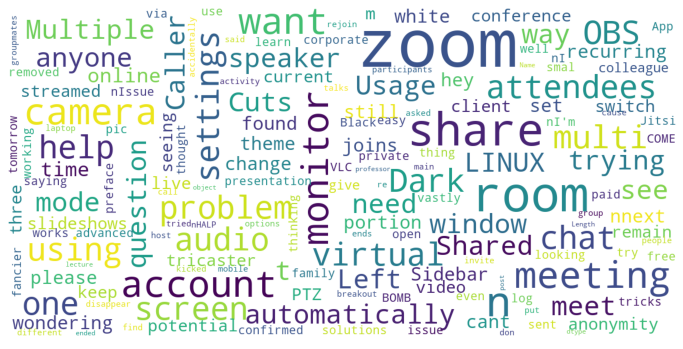

In [24]:
# Lets look at wordcloud of the data for post
show_wordcloud(zoom_df['post'])

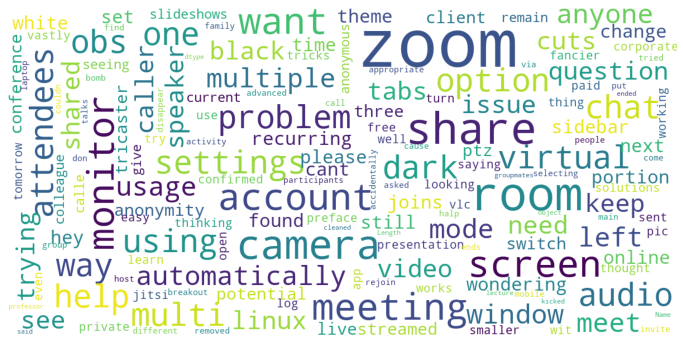

In [25]:
# Lets look at wordcloud of the data for cleaned
show_wordcloud(combined_df.loc[combined_df['subreddit'] == 'Zoom','cleaned'])

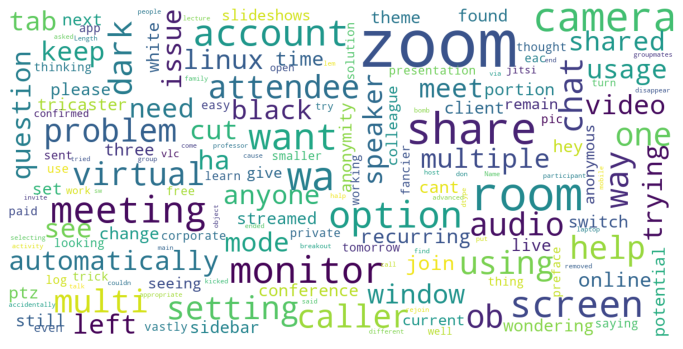

In [26]:
# Lets look at wordcloud of the data for lem
show_wordcloud(combined_df.loc[combined_df['subreddit'] == 'Zoom','lem'])

#### Microsoft Teams
Below are wordclouds for microsoft teams

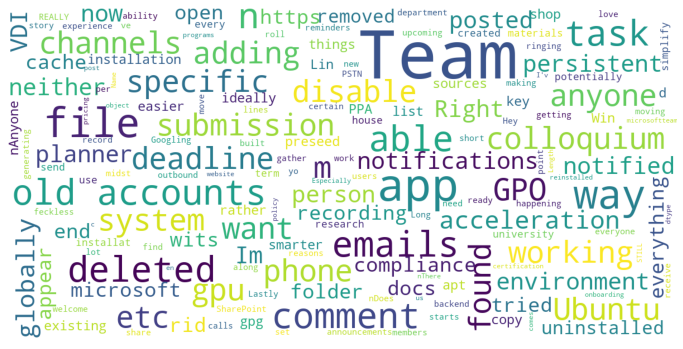

In [27]:
# Lets look at wordcloud of the data for post
show_wordcloud(mst_df['post'])

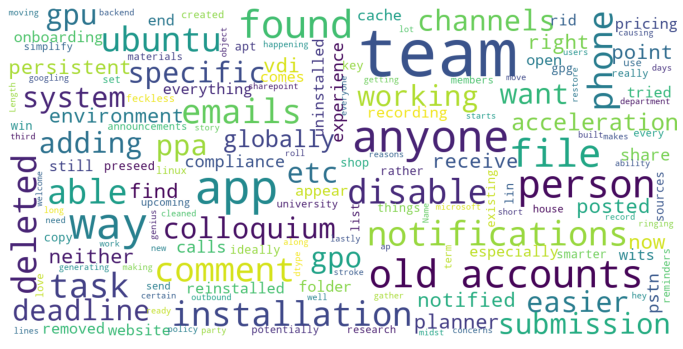

In [28]:
# Lets look at wordcloud of the data for cleaned
show_wordcloud(combined_df.loc[combined_df['subreddit'] == 'MicrosoftTeams','cleaned'])

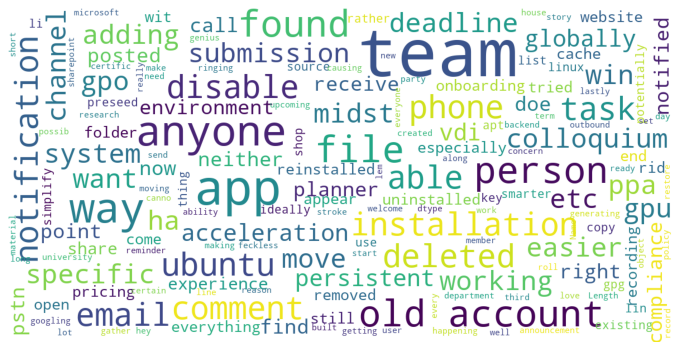

In [29]:
# Lets look at wordcloud of the data for lem
show_wordcloud(combined_df.loc[combined_df['subreddit'] == 'MicrosoftTeams','lem'])

We can see that the name of the video conferencing tool itself is the most popular word for both `Zoom` and `Microsoft Team`.

### Top words that are in common
1. Using `CountVectorizer`
2. Using `TfidfVectorizer`

We will first vectorize the text by using `CountVectorizer`.

In [30]:
# Let's add a few more stop words that were not captured
from sklearn.feature_extraction import text

text.ENGLISH_STOP_WORDS

add_stop_words = ['', 'x200b', 'don', 'will', 'etc', 'well', 'got', 'ha', 'isn', 'wa','want','aren', 'couldn', 'didn', 'doesn', 'don',
                  'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn']

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

stop_words

frozenset({'',
           'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'aren',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
       

In [31]:
# for Zoom
# instantiate CountVectorizer
ngrams_cv_zoom = CountVectorizer(stop_words=stop_words,
                                 max_features = 1000,
                                 ngram_range=(1, 3))

# fit and transform the model
cv_words_zoom = ngrams_cv_zoom.fit_transform(combined_df.loc[(combined_df['subreddit']=='Zoom'),'lem'])
# cv_words
# convert trandsformed data to dataframe
cv_matrix_words_zoom = cv_words_zoom.todense()   # converts to matrix
#print(matrix_words)
df_cv_words_zoom = pd.DataFrame(cv_matrix_words_zoom, columns=ngrams_cv_zoom.get_feature_names())

# look at the dataframe head and shape
print(df_cv_words_zoom.shape)

# top 15 most common words
cv_words_zoom20 = df_cv_words_zoom.sum().sort_values(ascending=False).head(20)
cv_words_zoom20

(15150, 1000)


zoom            18412
meeting          8159
removed          3680
screen           3655
video            3588
audio            2964
host             2591
room             2411
just             2340
way              2274
join             2224
time             2149
use              2123
know             2122
using            2068
help             2041
zoom meeting     2002
class            1970
doe              1939
like             1939
dtype: int64

In [32]:
# for MicrosoftTeams
# instantiate CountVectorizer
ngrams_cv_mst = CountVectorizer(stop_words=stop_words,
                                 max_features = 1000,
                                 ngram_range=(1, 3))

# fit and transform the model
cv_words_mst = ngrams_cv_mst.fit_transform(combined_df.loc[(combined_df['subreddit']=='MicrosoftTeams'),'lem'])
# cv_words
# convert trandsformed data to dataframe
cv_matrix_words_mst = cv_words_mst.todense()   # converts to matrix
#print(matrix_words)
df_cv_words_mst = pd.DataFrame(cv_matrix_words_mst, columns=ngrams_cv_mst.get_feature_names())

# look at the dataframe head and shape
print(df_cv_words_mst.shape)

# top 15 most common words
cv_words_mst20 = df_cv_words_mst.sum().sort_values(ascending=False).head(20)
cv_words_mst20

(13137, 1000)


team         31002
meeting       9508
user          7760
work          5614
just          5594
microsoft     5472
app           4879
use           4841
way           4806
like          4751
using         4475
issue         4434
phone         4120
know          3853
chat          3843
time          3795
doe           3537
people        3256
account       3202
channel       3156
dtype: int64

In [33]:
# Code reference from https://github.com/cheekeet86/project_3/blob/master/code/project_3.ipynb
# get top words in zoom_df

df_top_zoomcv = cv_words_zoom20.to_frame(name='count')
df_top_zoomcv['word'] = df_top_zoomcv.index
df_top_zoomcv.reset_index(drop=True, inplace=True)
df_top_zoomcv['freq'] = df_top_zoomcv['count'] / len(zoom_df) * 100

cols = ['word','count','freq']
df_top_zoomcv = df_top_zoomcv[cols]
df_top_zoomcv.sort_values(by='count',ascending=False, inplace=True)
df_top_zoomcv.head(10)

,word,count,freq
0,zoom,18412,121.531353
1,meeting,8159,53.854785
2,removed,3680,24.290429
3,screen,3655,24.125413
4,video,3588,23.683168
5,audio,2964,19.564356
6,host,2591,17.102310
7,room,2411,15.914191
8,just,2340,15.445545
9,way,2274,15.009901


In [34]:
# Code reference from https://github.com/cheekeet86/project_3/blob/master/code/project_3.ipynb
# get top words in mst_df

df_top_mstcv = cv_words_mst20.to_frame(name='count')
df_top_mstcv['word'] = df_top_mstcv.index
df_top_mstcv.reset_index(drop=True, inplace=True)
df_top_mstcv['freq'] = df_top_mstcv['count'] / len(mst_df) * 100

cols = ['word','count','freq']
df_top_mstcv = df_top_mstcv[cols]
df_top_mstcv.sort_values(by='count',ascending=False, inplace=True)
df_top_mstcv.head(10)

,word,count,freq
0,team,31002,235.989952
1,meeting,9508,72.375733
2,user,7760,59.069803
3,work,5614,42.734262
4,just,5594,42.582020
5,microsoft,5472,41.653346
6,app,4879,37.139377
7,use,4841,36.850118
8,way,4806,36.583695
9,like,4751,36.165030


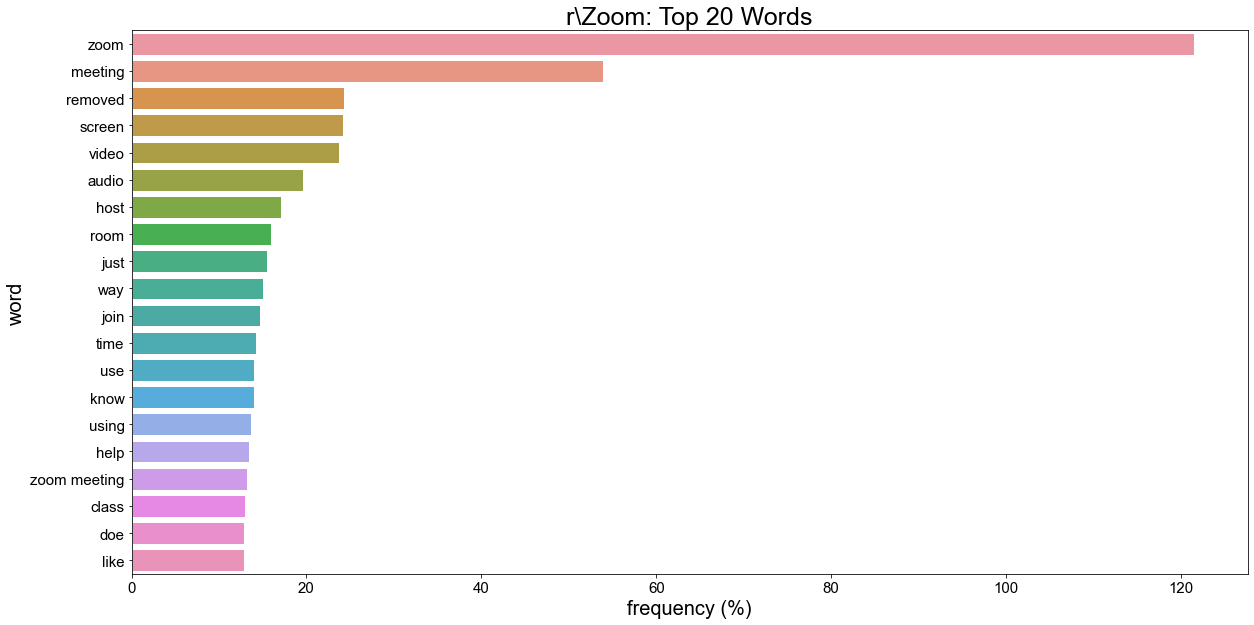

In [35]:
# Code reference from https://github.com/cheekeet86/project_3/blob/master/code/project_3.ipynb
plt.figure(figsize=(20,10))
plt.title('r\Zoom: Top 20 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=df_top_zoomcv.head(20),x='freq',y='word',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

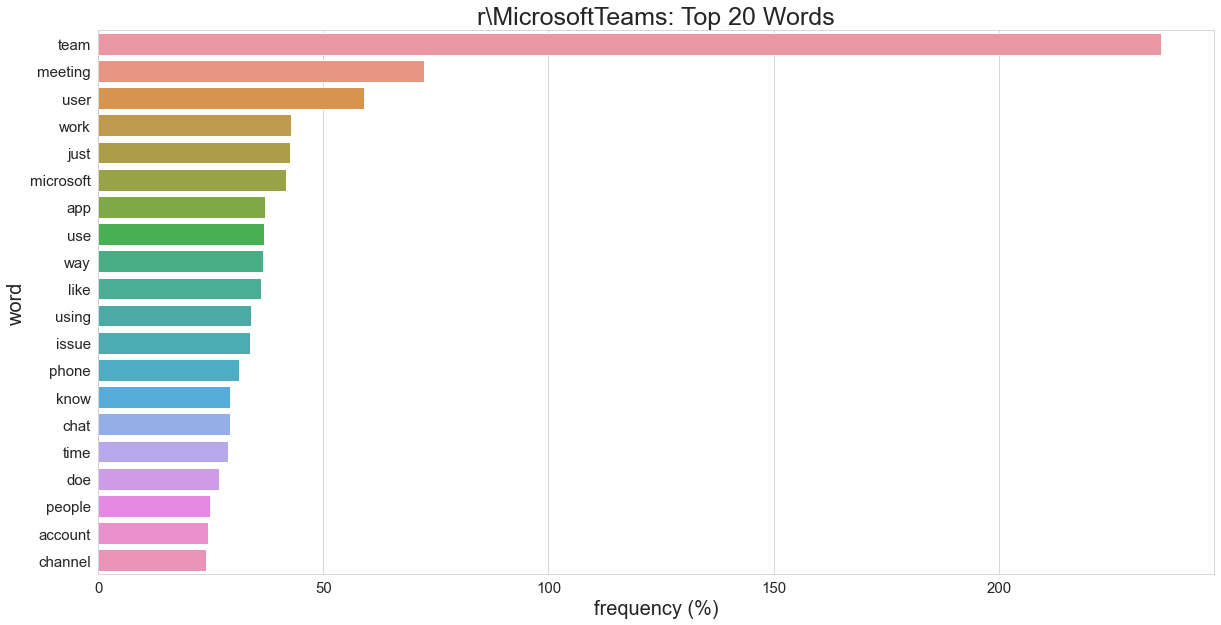

In [36]:
# Code reference from https://github.com/cheekeet86/project_3/blob/master/code/project_3.ipynb
plt.figure(figsize=(20,10))
plt.title('r\MicrosoftTeams: Top 20 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=df_top_mstcv.head(20),x='freq',y='word',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

Venn Diagram below shows the top 20 words for both subreddits.


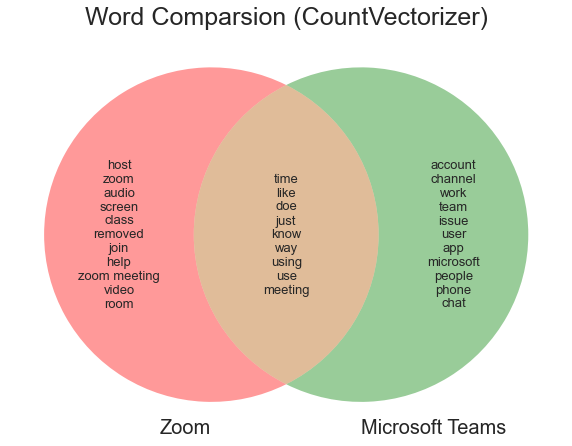

In [37]:
# Code reference from https://github.com/cheekeet86/project_3/blob/master/code/project_3.ipynb
plt.figure(figsize=(10,10))
plt.title('Word Comparsion (CountVectorizer)',fontsize=25)

set_a = set(df_top_zoomcv['word'][:20])
set_b = set(df_top_mstcv['word'][:20])

venn = venn2([set_a,set_b],set_labels=['Zoom','Microsoft Teams'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

print('Venn Diagram below shows the top 20 words for both subreddits.')

We will now vectorize the text by using `TfidfVectorizer`

In [38]:
# For Zoom
# instantiate TfidfVectorizer
ngrams_tvec_zoom = TfidfVectorizer(stop_words=stop_words,
                                   max_features = 1000,
                                   ngram_range=(1, 3))

# fit and transform the model
tvec_words_zoom = ngrams_tvec_zoom.fit_transform(combined_df.loc[(combined_df['subreddit']=='Zoom'),'lem'])
# cv_words
# convert trandsformed data to dataframe
tvec_matrix_words_zoom = tvec_words_zoom.todense()   # converts to matrix
#print(matrix_words)
df_tvec_words_zoom = pd.DataFrame(tvec_matrix_words_zoom, columns=ngrams_cv_zoom.get_feature_names())

# look at the dataframe head and shape
print(df_tvec_words_zoom.shape)

# top 20 most common words
tvec_words_zoom20 = df_tvec_words_zoom.sum().sort_values(ascending=False).head(20)
tvec_words_zoom20

(15150, 1000)


zoom            1375.890285
removed         1125.519767
meeting          756.700552
join             547.461884
video            414.863361
screen           406.106852
audio            353.590611
class            337.457960
host             326.243069
zoom meeting     313.277594
room             287.490380
help             264.980105
way              263.882012
just             251.265396
know             247.318255
participant      246.356904
time             246.134032
camera           245.661952
doe              239.050780
use              234.546254
dtype: float64

In [39]:
# for Microsoft Teams
# instantiate TfidfVectorizer
ngrams_tvec_mst = TfidfVectorizer(stop_words=stop_words,
                                   max_features = 1000,
                                   ngram_range=(1, 3))

# fit and transform the model
tvec_words_mst = ngrams_tvec_mst.fit_transform(combined_df.loc[(combined_df['subreddit']=='Zoom'),'lem'])
# cv_words
# convert trandsformed data to dataframe
tvec_matrix_words_mst = tvec_words_mst.todense()   # converts to matrix
#print(matrix_words)
df_tvec_words_mst = pd.DataFrame(tvec_matrix_words_mst, columns=ngrams_tvec_mst.get_feature_names())

# look at the dataframe head and shape
print(df_tvec_words_mst.shape)

# top 20 most common words
tvec_words_mst20 = df_tvec_words_mst.sum().sort_values(ascending=False).head(20)
tvec_words_mst20

(15150, 1000)


zoom            1375.890285
removed         1125.519767
meeting          756.700552
join             547.461884
video            414.863361
screen           406.106852
audio            353.590611
class            337.457960
host             326.243069
zoom meeting     313.277594
room             287.490380
help             264.980105
way              263.882012
just             251.265396
know             247.318255
participant      246.356904
time             246.134032
camera           245.661952
doe              239.050780
use              234.546254
dtype: float64

In [40]:
# Code reference from https://github.com/cheekeet86/project_3/blob/master/code/project_3.ipynb
# get top words in zoom_df

df_top_zoomtv = tvec_words_zoom20.to_frame(name='count')
df_top_zoomtv['word'] = df_top_zoomtv.index
df_top_zoomtv.reset_index(drop=True, inplace=True)
df_top_zoomtv['freq'] = df_top_zoomtv['count'] / len(zoom_df) * 100

cols = ['word','count','freq']
df_top_zoomtv = df_top_zoomtv[cols]
df_top_zoomtv.sort_values(by='count',ascending=False, inplace=True)
df_top_zoomtv.head(10)

,word,count,freq
0,zoom,1375.890285,9.081784
1,removed,1125.519767,7.429173
2,meeting,756.700552,4.994723
3,join,547.461884,3.613610
4,video,414.863361,2.738372
5,screen,406.106852,2.680573
6,audio,353.590611,2.333931
7,class,337.457960,2.227445
8,host,326.243069,2.153420
9,zoom meeting,313.277594,2.067839


In [41]:
# Code reference from https://github.com/cheekeet86/project_3/blob/master/code/project_3.ipynb
# get top words in mst_df

df_top_msttv = tvec_words_mst20.to_frame(name='count')
df_top_msttv['word'] = df_top_msttv.index
df_top_msttv.reset_index(drop=True, inplace=True)
df_top_msttv['freq'] = df_top_msttv['count'] / len(mst_df) * 100

cols = ['word','count','freq']
df_top_msttv = df_top_msttv[cols]
df_top_msttv.sort_values(by='count',ascending=False, inplace=True)
df_top_msttv.head(10)

,word,count,freq
0,zoom,1375.890285,10.473398
1,removed,1125.519767,8.567556
2,meeting,756.700552,5.760071
3,join,547.461884,4.167328
4,video,414.863361,3.157976
5,screen,406.106852,3.091321
6,audio,353.590611,2.691563
7,class,337.457960,2.568760
8,host,326.243069,2.483391
9,zoom meeting,313.277594,2.384697


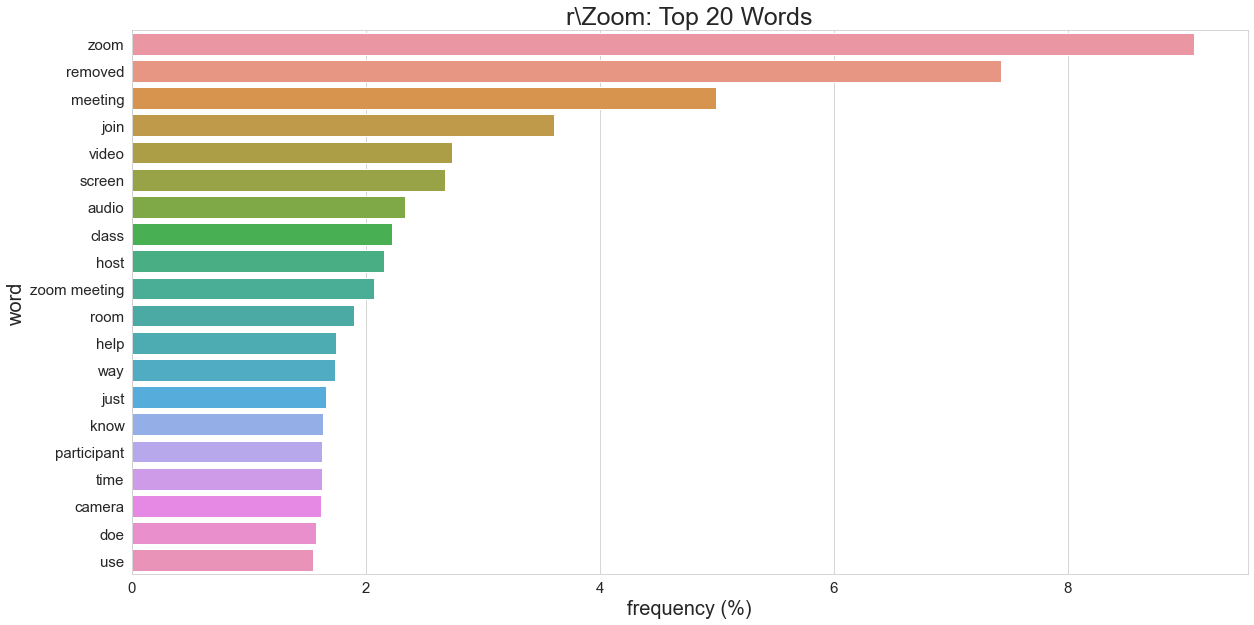

In [42]:
# Code reference from https://github.com/cheekeet86/project_3/blob/master/code/project_3.ipynb
plt.figure(figsize=(20,10))
plt.title('r\Zoom: Top 20 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=df_top_zoomtv.head(20),x='freq',y='word',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

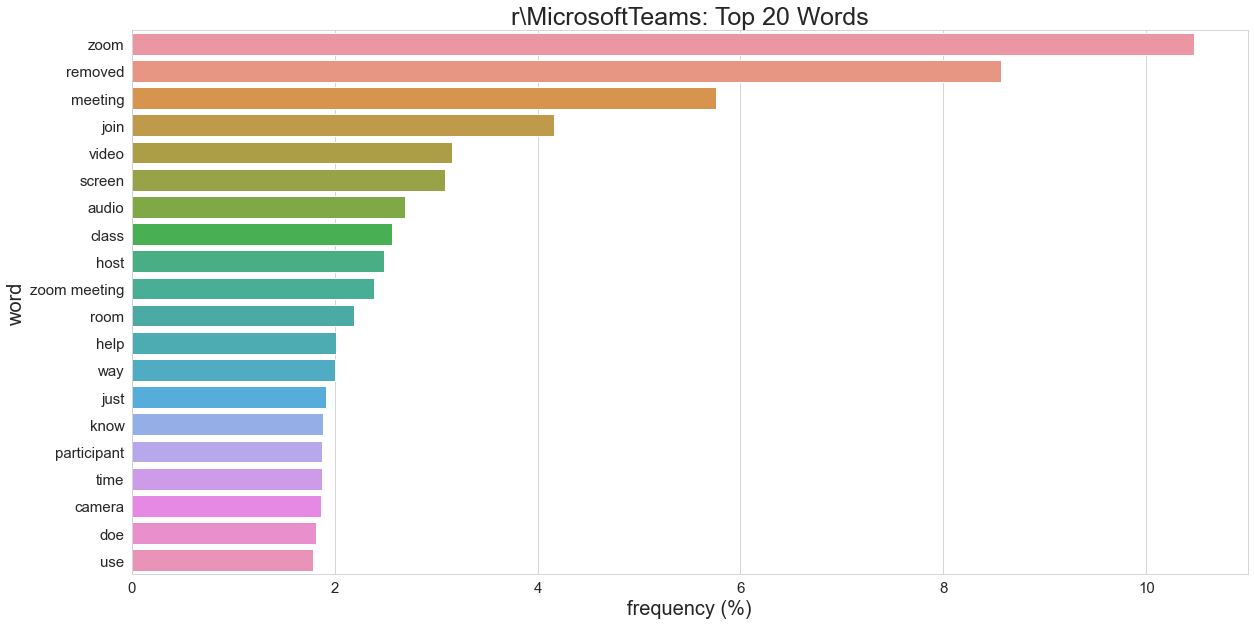

In [43]:
# Code reference from https://github.com/cheekeet86/project_3/blob/master/code/project_3.ipynb
plt.figure(figsize=(20,10))
plt.title('r\MicrosoftTeams: Top 20 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=df_top_msttv.head(20),x='freq',y='word',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

Venn Diagram below shows the top 20 words for both subreddits.


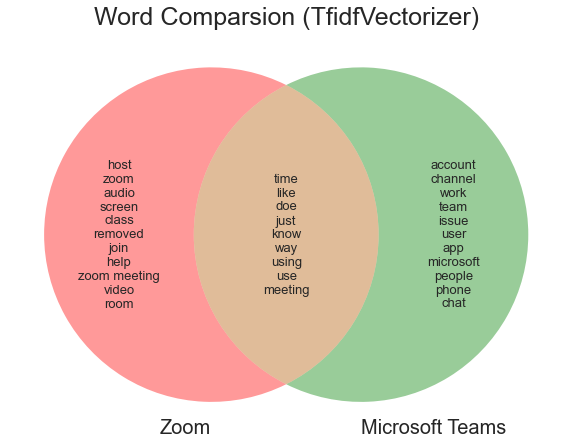

In [44]:
# Code reference from https://github.com/cheekeet86/project_3/blob/master/code/project_3.ipynb
plt.figure(figsize=(10,10))
plt.title('Word Comparsion (TfidfVectorizer)',fontsize=25)

set_a = set(df_top_zoomcv['word'][:20])
set_b = set(df_top_mstcv['word'][:20])

venn = venn2([set_a,set_b],set_labels=['Zoom','Microsoft Teams'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

print('Venn Diagram below shows the top 20 words for both subreddits.')

We see that even though we employed different vectorizer (transformer), the top twenty words are the same. 

### Sentiment Analysis
We will use the Sentiment Intensity Analyzer to perform Sentiment Analysis of the submissions and assign the 4 scores to columns in the dataframe. 

This will be performed on the original `post`, and not on the `cleaned` post to capture what the users had submitted in the subreddit

- From the VADER documentation [Link](https://github.com/cjhutto/vaderSentiment#about-the-scoring):
    - positive sentiment: compound score >= 0.05
    - neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
    - negative sentiment: compound score <= -0.05
    *NOTE: The compound score is the one most commonly used for sentiment analysis by most researchers, including the authors.*

In [45]:
# look at head for post in combined_df
combined_df[['post']].head()

,post
0,Zoom room online all the time I want to have a recurring meeting I want automatically any one who joins to room?
1,Multiple Usage Zoom How can I multiple usages automatically meet on zoom?
2,Dark mode in chats I was wondering if anyone had found a way to get the chat portion of Zoom to change to a dark mode? I have the Left Sidebar theme set to Dark but the chat window is still white.
3,"zoom multi-monitor hey, I have a problem with the zoom I can't share multi-monitor on zoom room how can I share multi-monitor please help me ??\n\nnext question we're meeting zoom room but we cant share all monitor why?"
4,"Caller anonymity question I have a potential client who has a conference that needs to be live streamed. I’m using a tricaster with three PTZ cameras to switch between the in room speakers, slideshows and zoom callers. They want to attendees in the room to see the video from the current zoom speaker but they want to keep the other zoom attendees from seeing each other. They all need to remain ..."


In [46]:
%%time
# Sentiment Analysis of the posts
combined_df['sen_analysis'] = [SentimentIntensityAnalyzer().polarity_scores(
    combined_df.loc[i,'post']) for i in range(combined_df.shape[0])]

Wall time: 3min 14s


In [47]:
# look at shape for combined_df
print(combined_df.shape)

# look at head for a specific group of columns in head
combined_df[['post', 'sen_analysis']].head()

(28287, 11)


,post,sen_analysis
0,Zoom room online all the time I want to have a recurring meeting I want automatically any one who joins to room?,"{'neg': 0.0, 'neu': 0.867, 'pos': 0.133, 'compound': 0.1531}"
1,Multiple Usage Zoom How can I multiple usages automatically meet on zoom?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,Dark mode in chats I was wondering if anyone had found a way to get the chat portion of Zoom to change to a dark mode? I have the Left Sidebar theme set to Dark but the chat window is still white.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
3,"zoom multi-monitor hey, I have a problem with the zoom I can't share multi-monitor on zoom room how can I share multi-monitor please help me ??\n\nnext question we're meeting zoom room but we cant share all monitor why?","{'neg': 0.19, 'neu': 0.723, 'pos': 0.087, 'compound': -0.4784}"
4,"Caller anonymity question I have a potential client who has a conference that needs to be live streamed. I’m using a tricaster with three PTZ cameras to switch between the in room speakers, slideshows and zoom callers. They want to attendees in the room to see the video from the current zoom speaker but they want to keep the other zoom attendees from seeing each other. They all need to remain ...","{'neg': 0.035, 'neu': 0.881, 'pos': 0.083, 'compound': 0.7275}"


In [48]:
%%time
# create 4 seperate columns from the sentiment analysis score
combined_df['neg_sen_analysis'] = [combined_df.loc[i, 'sen_analysis']['neg'] for i in range(combined_df.shape[0])]
combined_df['neu_sen_analysis'] = [combined_df.loc[i, 'sen_analysis']['neu'] for i in range(combined_df.shape[0])]
combined_df['pos_sen_analysis'] = [combined_df.loc[i, 'sen_analysis']['pos'] for i in range(combined_df.shape[0])]
combined_df['com_sen_analysis'] = [combined_df.loc[i, 'sen_analysis']['compound'] for i in range(combined_df.shape[0])]

Wall time: 734 ms


In [49]:
# look at shape for combined_df
print(combined_df.shape)

# look at head for a specific group of columns in head
combined_df[['post', 'sen_analysis', 'neg_sen_analysis', 'neu_sen_analysis',
             'pos_sen_analysis', 'com_sen_analysis']].head()

(28287, 15)


,post,sen_analysis,neg_sen_analysis,neu_sen_analysis,pos_sen_analysis,com_sen_analysis
0,Zoom room online all the time I want to have a recurring meeting I want automatically any one who joins to room?,"{'neg': 0.0, 'neu': 0.867, 'pos': 0.133, 'compound': 0.1531}",0.000,0.867,0.133,0.1531
1,Multiple Usage Zoom How can I multiple usages automatically meet on zoom?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000
2,Dark mode in chats I was wondering if anyone had found a way to get the chat portion of Zoom to change to a dark mode? I have the Left Sidebar theme set to Dark but the chat window is still white.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.000,1.000,0.000,0.0000
3,"zoom multi-monitor hey, I have a problem with the zoom I can't share multi-monitor on zoom room how can I share multi-monitor please help me ??\n\nnext question we're meeting zoom room but we cant share all monitor why?","{'neg': 0.19, 'neu': 0.723, 'pos': 0.087, 'compound': -0.4784}",0.190,0.723,0.087,-0.4784
4,"Caller anonymity question I have a potential client who has a conference that needs to be live streamed. I’m using a tricaster with three PTZ cameras to switch between the in room speakers, slideshows and zoom callers. They want to attendees in the room to see the video from the current zoom speaker but they want to keep the other zoom attendees from seeing each other. They all need to remain ...","{'neg': 0.035, 'neu': 0.881, 'pos': 0.083, 'compound': 0.7275}",0.035,0.881,0.083,0.7275


Let us now look at the compound score in a graph.

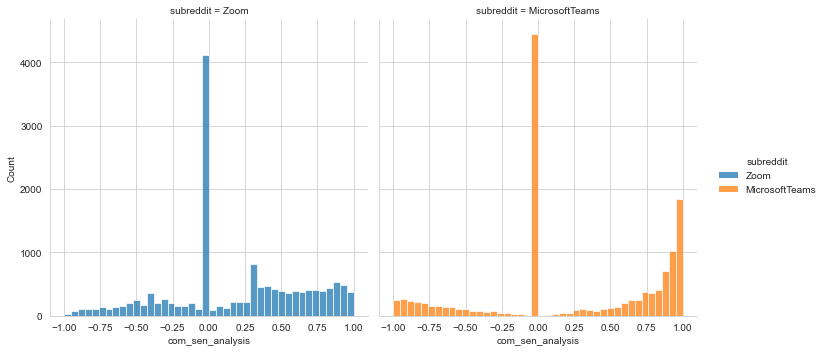

In [50]:
# for compound score
sns.displot(combined_df, x='com_sen_analysis', col='subreddit', hue='subreddit');

From above graph, we see that majority of the compound scores lies at $0$. This suggests the submissions at the subreddits are mostly of neutral stand. 

We also could infer that a large number of submissions in `MicrosoftTeams` are of extreme positive sentiment (peak near $1$), whereas the sentiment for submissions in `Zoom` are more balanced, with more submissions having a positive score as compared to negative. 

In [51]:
# lets look at some calculated values of the compound score
combined_df.groupby('subreddit')['com_sen_analysis'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
MicrosoftTeams,13137.0,0.258507,0.600548,-0.9988,0.0,0.0000,0.8798,0.9998
Zoom,15150.0,0.188421,0.465824,-0.9977,0.0,0.0772,0.5719,0.9992


From the table, we can infer that 
1. `MicrosoftTeams` had a slightly higher maximum compound score (0.0006) and a lower minimum compound score than `Zoom`.
2. `Zoom` had 50% or more data having positive compound score. 
3. `Zoom` has a smaller spread (smaller std) of compound score. 

### Time Period
As there is a huge time period for the analysis, we would like to take a look at the peak of the submissions and take a year worth of data. Let us first look at the number of submissions over time.

Although we have `datetime_utc` and `datetime_local`, we will use `datetime_utc` for our analysis as `datetime_local` might result in slightly different conclusion depending on where the code is run at. 

In [52]:
# get date_utc of posts
combined_df['date_utc'] = pd.to_datetime(combined_df['datetime_utc']).dt.normalize()

In [53]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28287 entries, 0 to 28286
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                28287 non-null  object        
 1   author            28287 non-null  object        
 2   subreddit         28287 non-null  object        
 3   selftext          28287 non-null  object        
 4   title             28287 non-null  object        
 5   datetime_utc      28287 non-null  datetime64[ns]
 6   datetime_local    28287 non-null  datetime64[ns]
 7   post              28287 non-null  object        
 8   cleaned           28287 non-null  object        
 9   lem               28287 non-null  object        
 10  sen_analysis      28287 non-null  object        
 11  neg_sen_analysis  28287 non-null  float64       
 12  neu_sen_analysis  28287 non-null  float64       
 13  pos_sen_analysis  28287 non-null  float64       
 14  com_sen_analysis  2828

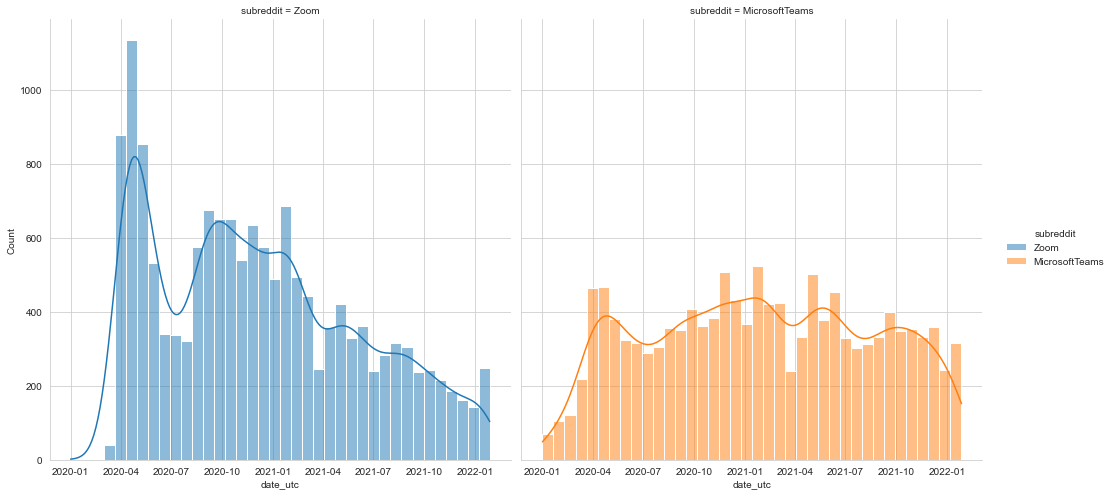

In [54]:
# for submissions over time period
sns.displot(combined_df, x='date_utc', col='subreddit', hue='subreddit', kde=True, height=7);

From the graphs, we can see that submissions in `Zoom` subreddit spiked in **Apr 2020** before fluctuating which submissions in `Microsoft Teams` remains relatively consistent after rising in **Apr 2020**. 

As such, we will take the submissions from **01 Apr 2020** to **31 Mar 2021** for our modelling purpose below. 

In [55]:
# create the mask that will be used for modelling below

# set the start and end date
start_date = '2020-04-01'
end_date = '2021-03-21'

# set the mask
time_mask = (combined_df['date_utc'] >= start_date) & (combined_df['date_utc'] <= end_date)

---

## Modeling

We will use 1 year work of lemmatized column of data, 1 Apr 2020 to 31 Mar 2021 for modelling. 

We will use pipeline to build our model. 

In [56]:
# Number of rows that will be used for modelling
combined_df.loc[time_mask,:].shape

# breakdown of dataframe

# number of zoom subreddit
# combined_df.loc[mask&(combined_df['subreddit']=='Zoom'),:].shape
# (10656, 16)

# number of microsoft teams subreddit
# combined_df.loc[mask&(combined_df['subreddit']=='MicrosoftTeams'),:].shape
# (6944, 16)

# number of submissions not used in modelling
# combined_df.loc[~mask,:].shape
# (10364, 16)

(17600, 16)

In [57]:
# lets take a look at the first 5 rows of the data
combined_df.loc[time_mask,['lem']].head()

,lem
306,can keep back screen with video off also have profile photo like keep the standard black screen with name when video off but also like the small profile photo this possible edit there typo title should read black screen
307,drop code class something going right now
308,au zoom storm deleted
309,link anyone have zoom link can join
310,zoom class for multivariable calculus into statistic intro chem can anyone some class code for multivariable calculus into statistic intro chem others are cool well but particularly interested the above looking for class english looking learn will not share the code thanks


Let's create another column in the dataframe and name it `target`, where 1 is zoom, 0 is microsoft teams

In [58]:
combined_df['target'] = [1 if x == 'Zoom' else 0 for x in combined_df['subreddit']]
print(combined_df['target'][:10])
print(combined_df['target'][-10:])

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: target, dtype: int64
28277    0
28278    0
28279    0
28280    0
28281    0
28282    0
28283    0
28284    0
28285    0
28286    0
Name: target, dtype: int64


### Set Variables

In [59]:
# Set Feature array 
# array is set instead of dataframe as we will be performing either CountVectorizer or TfidfVectorizer on X
X = combined_df.loc[time_mask,'lem']

# set target array
y = combined_df.loc[time_mask,'target']

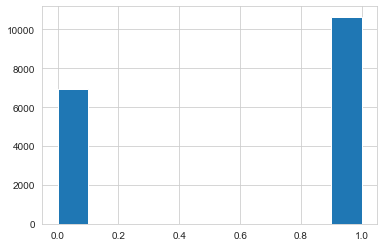

In [60]:
# we see that the data is not split equally among the data
plt.hist(y);

### Train-Test Split

In [61]:
# define training set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,   # test-size of 30%
                                                    stratify=y,    # as set is imbalance, we need to stratify
                                                    random_state=42)

### Baseline accuracy
We will use predicting based on majority class as our baseline model. 

Running the below code, we noticed that we predicting everything as the majority class will give us 60.5% accuracy. 

In [62]:
y_test.value_counts(normalize=True)

1    0.605492
0    0.394508
Name: target, dtype: float64

We will run 4 classifier models along with `CountVectorizer` or `TfidfVectorizer`
1. Naive Bayes Model
2. Logistric Regression
3. Random Forest
4. K Nearest Neighbors

### Naive Bayes model

In [63]:
# Set a pipeline up with two stages
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_CVNB = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('nb', MultinomialNB())
])

In [64]:
# Estimate how the model will perform on unseen data
print(f"Cross Validated Score of pipline: {cross_val_score(pipe_CVNB, X_train, y_train, cv=10).mean()}")

# fit model
pipe_CVNB.fit(X_train, y_train)

# model score on training and testing data
print(f"Train Score: {pipe_CVNB.score(X_train, y_train)}")
print(f"Test Score: {pipe_CVNB.score(X_test, y_test)}")

Cross Validated Score of pipline: 0.8425324675324676
Train Score: 0.8625
Test Score: 0.8380681818181818


Score is not bad but let's expand it using a `GridSearch`.

In [65]:
# set pipeline parameters
pipe_CVNB_params = {
    'cvec__max_features' : [2_000, 3_000, 4_000, 5_000, 6_000, 7_000, 8_000, 9_000, 10_000],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

In [66]:
# Instantiate GridSearchCV

gs_CVNB = GridSearchCV(pipe_CVNB,   # object being optimized
                    param_grid=pipe_CVNB_params,  # what paramenters values are being searched
                    cv=5   # number of cross-validation
                    )

In [67]:
%%time

# fit gridsearchCV to training data
gs_CVNB.fit(X_train, y_train)

Wall time: 1min 13s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'',
                                                                              'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                  

In [68]:
# Get Gridsearch best score
print(f"GridSearch best score: {gs_CVNB.best_score_}")

GridSearch best score: 0.8819805194805195


In [69]:
# get the best parameters
gs_CVNB.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=4000, ngram_range=(1, 2),
                                 stop_words=frozenset({'', 'a', 'about',
                                                       'above', 'across',
                                                       'after', 'afterwards',
                                                       'again', 'against',
                                                       'all', 'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow'

In [70]:
# gs_CVNB model score
print(f"Train Score: {gs_CVNB.score(X_train, y_train)}")
print(f"Test Score: {gs_CVNB.score(X_test, y_test)}")

Train Score: 0.890422077922078
Test Score: 0.8778409090909091


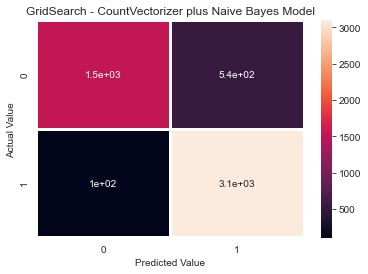

Accuracy: 0.8778409090909091


In [71]:
# get predictions
preds_gsCVNB = gs_CVNB.predict(X_test)

# save confusion matrix values
# tn, fp, fn, tp = confusion_matrix(y_test, preds_gsCVNB).ravel()

# view confusion matrix

# color map
# cmap = sb.diverging_palette(0, 230, 90, 60, as_cmap=True)

# plot heatmap
ax = sns.heatmap(confusion_matrix(y_test, preds_gsCVNB),annot=True, linewidths=2)
ax.set(xlabel='Predicted Value', ylabel='Actual Value')
plt.title("GridSearch - CountVectorizer plus Naive Bayes Model")
plt.show()

# Accuracy of model
print(f"Accuracy: {accuracy_score(y_test, preds_gsCVNB)}")

The model is not bad but let's change the transformer to `TfidfVectorizer`.

In [72]:
# Set a pipeline up with two stages
# 1. TfidfVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_TVNB = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop_words)),
    ('nb', MultinomialNB())
])

In [73]:
# Estimate how the model will perform on unseen data
print(f"Cross Validated Score of pipline: {cross_val_score(pipe_TVNB, X_train, y_train, cv=10).mean()}")

# fit model
pipe_TVNB.fit(X_train, y_train)

# model score on training and testing data
print(f"Train Score: {pipe_TVNB.score(X_train, y_train)}")
print(f"Test Score: {pipe_TVNB.score(X_test, y_test)}")

Cross Validated Score of pipline: 0.8025974025974026
Train Score: 0.83125
Test Score: 0.7910984848484849


Score is not bad but let's expand it using a `GridSearch`.

In [74]:
# set pipeline parameters
pipe_TVNB_params = {
    'tvec__max_features' : range(2000, 10_000, 1000),
    'tvec__ngram_range' : [(1,1), (1,2)]
}

In [75]:
# Instantiate GridSearchCV

gs_TVNB = GridSearchCV(pipe_TVNB,   # object being optimized
                    param_grid=pipe_TVNB_params,  # what paramenters values are being searched
                    cv=5   # number of cross-validation
                    )

In [76]:
%%time

# fit gridsearchCV to training data
gs_TVNB.fit(X_train, y_train)

Wall time: 1min 5s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=frozenset({'',
                                                                              'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                  

In [77]:
# Get Gridsearch best score
print(f"GridSearch best score: {gs_TVNB.best_score_}")

GridSearch best score: 0.8654220779220779


In [78]:
# get the best parameters
gs_TVNB.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=4000, ngram_range=(1, 2),
                                 stop_words=frozenset({'', 'a', 'about',
                                                       'above', 'across',
                                                       'after', 'afterwards',
                                                       'again', 'against',
                                                       'all', 'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow'

In [79]:
# gs_TVNB model score
print(f"Train Score: {gs_TVNB.score(X_train, y_train)}")
print(f"Test Score: {gs_TVNB.score(X_test, y_test)}")

Train Score: 0.8815746753246754
Test Score: 0.8606060606060606


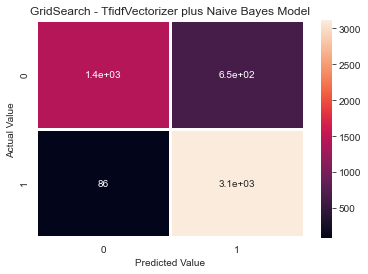

Accuracy: 0.8606060606060606


In [80]:
# get predictions
preds_gsTVNB = gs_TVNB.predict(X_test)

# save confusion matrix values
# tn, fp, fn, tp = confusion_matrix(y_test, preds_gsCVNB).ravel()

# view confusion matrix

# color map
# cmap = sb.diverging_palette(0, 230, 90, 60, as_cmap=True)

# plot heatmap
ax = sns.heatmap(confusion_matrix(y_test, preds_gsTVNB),annot=True, linewidths=2)
ax.set(xlabel='Predicted Value', ylabel='Actual Value')
plt.title("GridSearch - TfidfVectorizer plus Naive Bayes Model")
plt.show()

# Accuracy of model
print(f"Accuracy: {accuracy_score(y_test, preds_gsTVNB)}")

## Logistic Regression

In [81]:
# Set a pipeline up with two stages
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe_CVLR = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('lr', LogisticRegression(solver='sag', max_iter=100_000))
])

In [82]:
%%time

# Estimate how the model will perform on unseen data
print(f"Cross Validated Score of pipline: {cross_val_score(pipe_CVLR, X_train, y_train, cv=10).mean()}")

# fit model
pipe_CVLR.fit(X_train, y_train)

# model score on training and testing data
print(f"Train Score: {pipe_CVLR.score(X_train, y_train)}")
print(f"Test Score: {pipe_CVLR.score(X_test, y_test)}")

Cross Validated Score of pipline: 0.8555194805194806
Train Score: 0.8737824675324676
Test Score: 0.853030303030303
Wall time: 1min 23s


Score is not bad but let's expand it using a `GridSearch`.

In [83]:
# set pipeline parameters
pipe_CVLR_params = {
    'cvec__max_features' : [2_000, 3_000, 4_000, 5_000, 6_000, 7_000, 8_000, 9_000, 10_000],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

In [84]:
# Instantiate GridSearchCV

gs_CVLR = GridSearchCV(pipe_CVLR,   # object being optimized
                    param_grid=pipe_CVLR_params,  # what paramenters values are being searched
                    cv=5   # number of cross-validation
                    )

In [85]:
%%time

# fit gridsearchCV to training data
gs_CVLR.fit(X_train, y_train)

Wall time: 16min 4s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'',
                                                                              'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                  

In [86]:
# Get Gridsearch best score
print(f"GridSearch best score: {gs_CVLR.best_score_}")

GridSearch best score: 0.890827922077922


In [87]:
# get the best parameters
gs_CVLR.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=2000, ngram_range=(1, 2),
                                 stop_words=frozenset({'', 'a', 'about',
                                                       'above', 'across',
                                                       'after', 'afterwards',
                                                       'again', 'against',
                                                       'all', 'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow'

In [88]:
# gs_CVLR model score
print(f"Train Score: {gs_CVLR.score(X_train, y_train)}")
print(f"Test Score: {gs_CVLR.score(X_test, y_test)}")

Train Score: 0.9089285714285714
Test Score: 0.8875


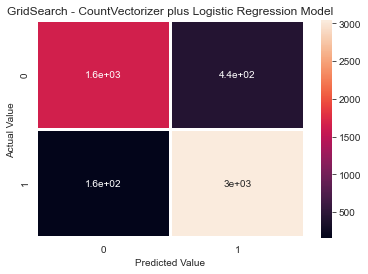

Accuracy: 0.8875


In [89]:
# get predictions
preds_gsCVLR = gs_CVLR.predict(X_test)

# save confusion matrix values
# tn, fp, fn, tp = confusion_matrix(y_test, preds_gsCVNB).ravel()

# view confusion matrix

# color map
# cmap = sb.diverging_palette(0, 230, 90, 60, as_cmap=True)

# plot heatmap
ax = sns.heatmap(confusion_matrix(y_test, preds_gsCVLR),annot=True, linewidths=2)
ax.set(xlabel='Predicted Value', ylabel='Actual Value')
plt.title("GridSearch - CountVectorizer plus Logistic Regression Model")
plt.show()

# Accuracy of model
print(f"Accuracy: {accuracy_score(y_test, preds_gsCVLR)}")

The model is not bad but let's change the transformer to `TfidfVectorizer`.

In [90]:
# Set a pipeline up with two stages
# 1. TfidfVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe_TVLR = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop_words)),
    ('lr', LogisticRegression(solver='sag', max_iter=100_000))
])

In [91]:
# Estimate how the model will perform on unseen data
print(f"Cross Validated Score of pipline: {cross_val_score(pipe_TVLR, X_train, y_train, cv=10).mean()}")

# fit model
pipe_TVLR.fit(X_train, y_train)

# model score on training and testing data
print(f"Train Score: {pipe_TVLR.score(X_train, y_train)}")
print(f"Test Score: {pipe_TVLR.score(X_test, y_test)}")

Cross Validated Score of pipline: 0.9218344155844157
Train Score: 0.9553571428571429
Test Score: 0.9240530303030303


Score is not bad but let's expand it using a `GridSearch`.

In [92]:
# set pipeline parameters
pipe_TVLR_params = {
    'tvec__max_features' : range(2000, 10_000, 1000),
    'tvec__ngram_range' : [(1,1), (1,2)]
}

In [93]:
# Instantiate GridSearchCV

gs_TVLR = GridSearchCV(pipe_TVLR,   # object being optimized
                    param_grid=pipe_TVLR_params,  # what paramenters values are being searched
                    cv=5   # number of cross-validation
                    )

In [94]:
%%time

# fit gridsearchCV to training data
gs_TVLR.fit(X_train, y_train)

Wall time: 1min 8s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=frozenset({'',
                                                                              'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                  

In [95]:
# Get Gridsearch best score
print(f"GridSearch best score: {gs_TVLR.best_score_}")

GridSearch best score: 0.9370129870129871


In [96]:
# get the best parameters
gs_TVLR.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=9000, ngram_range=(1, 2),
                                 stop_words=frozenset({'', 'a', 'about',
                                                       'above', 'across',
                                                       'after', 'afterwards',
                                                       'again', 'against',
                                                       'all', 'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow'

In [97]:
# gs_TVLR model score
print(f"Train Score: {gs_TVLR.score(X_train, y_train)}")
print(f"Test Score: {gs_TVLR.score(X_test, y_test)}")

Train Score: 0.9646915584415584
Test Score: 0.9428030303030303


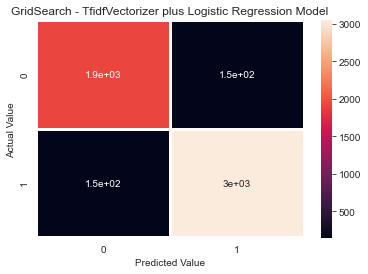

Accuracy: 0.9428030303030303


In [98]:
# get predictions
preds_gsTVLR = gs_TVLR.predict(X_test)

# save confusion matrix values
# tn, fp, fn, tp = confusion_matrix(y_test, preds_gsCVNB).ravel()

# view confusion matrix

# plot heatmap
ax = sns.heatmap(confusion_matrix(y_test, preds_gsTVLR),annot=True, linewidths=2)
ax.set(xlabel='Predicted Value', ylabel='Actual Value')
plt.title("GridSearch - TfidfVectorizer plus Logistic Regression Model")
plt.show()

# Accuracy of model
print(f"Accuracy: {accuracy_score(y_test, preds_gsTVLR)}")

## Random Forest Classifier

In [99]:
# Set a pipeline up with two stages
# 1. CountVectorizer (transformer)
# 2. RandomForestClassifier (estimator)

pipe_CVRF = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('rf', RandomForestClassifier())
])

In [100]:
%%time

# Estimate how the model will perform on unseen data
print(f"Cross Validated Score of pipline: {cross_val_score(pipe_CVRF, X_train, y_train, cv=10).mean()}")

# fit model
pipe_CVRF.fit(X_train, y_train)

# model score on training and testing data
print(f"Train Score: {pipe_CVRF.score(X_train, y_train)}")
print(f"Test Score: {pipe_CVRF.score(X_test, y_test)}")

Cross Validated Score of pipline: 0.9775162337662339
Train Score: 0.9991883116883117
Test Score: 0.9806818181818182
Wall time: 50 s


Score is not bad but let's expand it using a `GridSearch`.

In [101]:
# set pipeline parameters
pipe_CVRF_params = {
    'cvec__max_features' : [2_000, 3_000, 4_000, 5_000, 6_000, 7_000, 8_000, 9_000, 10_000],
    'cvec__ngram_range' : [(1,1), (1,2)],
    'rf__n_estimators': [100, 150, 200], # iterating over different number of trees in the forest
    'rf__max_depth': [None, 1, 2, 3, 4, 5], # iterating over a defined set of max depth of tree. For None, the nodes are expanded until all leaves are pure

}

In [102]:
# Instantiate GridSearchCV

gs_CVRF = GridSearchCV(pipe_CVRF,   # object being optimized
                    param_grid=pipe_CVRF_params,  # what paramenters values are being searched
                    cv=5   # number of cross-validation
                    )

In [103]:
%%time

# fit gridsearchCV to training data
gs_CVRF.fit(X_train, y_train)

Wall time: 45min 40s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'',
                                                                              'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                  

In [104]:
# Get Gridsearch best score
print(f"GridSearch best score: {gs_CVRF.best_score_}")

GridSearch best score: 0.9779220779220781


In [105]:
# get the best parameters
gs_CVRF.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=6000,
                                 stop_words=frozenset({'', 'a', 'about',
                                                       'above', 'across',
                                                       'after', 'afterwards',
                                                       'again', 'against',
                                                       'all', 'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
        

In [106]:
# gs_CVRF model score
print(f"Train Score: {gs_CVRF.score(X_train, y_train)}")
print(f"Test Score: {gs_CVRF.score(X_test, y_test)}")

Train Score: 0.9968344155844155
Test Score: 0.9821969696969697


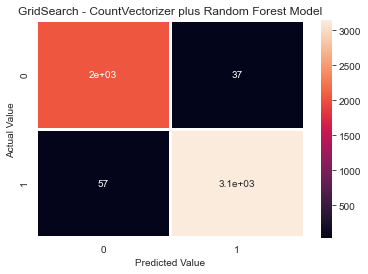

Accuracy: 0.9821969696969697


In [107]:
# get predictions
preds_gsCVRF = gs_CVRF.predict(X_test)

# save confusion matrix values
# tn, fp, fn, tp = confusion_matrix(y_test, preds_gsCVNB).ravel()

# view confusion matrix

# plot heatmap
ax = sns.heatmap(confusion_matrix(y_test, preds_gsCVRF),annot=True, linewidths=2)
ax.set(xlabel='Predicted Value', ylabel='Actual Value')
plt.title("GridSearch - CountVectorizer plus Random Forest Model")
plt.show()

# Accuracy of model
print(f"Accuracy: {accuracy_score(y_test, preds_gsCVRF)}")

The model is not bad but let's change the transformer to `TfidfVectorizer`.

In [108]:
# Set a pipeline up with two stages
# 1. TfidfVectorizer (transformer)
# 2. RandomForestClassifier (estimator)

pipe_TVRF = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop_words)),
    ('rf', RandomForestClassifier())
])

In [109]:
%%time

# Estimate how the model will perform on unseen data
print(f"Cross Validated Score of pipline: {cross_val_score(pipe_TVRF, X_train, y_train, cv=10).mean()}")

# fit model
pipe_TVRF.fit(X_train, y_train)

# model score on training and testing data
print(f"Train Score: {pipe_TVRF.score(X_train, y_train)}")
print(f"Test Score: {pipe_TVRF.score(X_test, y_test)}")

Cross Validated Score of pipline: 0.9303571428571429
Train Score: 0.9977272727272727
Test Score: 0.9380681818181819
Wall time: 1min 6s


Score is not bad but let's expand it using a `GridSearch`.

In [110]:
# set pipeline parameters
pipe_TVRF_params = {
    'tvec__max_features' : range(2000, 10_000, 1000),
    'tvec__ngram_range' : [(1,1), (1,2)],
    'rf__n_estimators': [100, 150, 200], # iterating over different number of trees in the forest
    'rf__max_depth': [None, 1, 2, 3, 4, 5], # iterating over a defined set of max depth of tree. For None, the nodes are expanded until all leaves are pure
}

In [111]:
# Instantiate GridSearchCV

gs_TVRF = GridSearchCV(pipe_TVRF,   # object being optimized
                    param_grid=pipe_TVRF_params,  # what paramenters values are being searched
                    cv=5   # number of cross-validation
                    )

In [112]:
%%time

# fit gridsearchCV to training data
gs_TVRF.fit(X_train, y_train)

Wall time: 48min 58s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=frozenset({'',
                                                                              'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                  

In [113]:
# Get Gridsearch best score
print(f"GridSearch best score: {gs_TVRF.best_score_}")

GridSearch best score: 0.9381493506493506


In [114]:
# get the best parameters
gs_TVRF.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words=frozenset({'', 'a', 'about',
                                                       'above', 'across',
                                                       'after', 'afterwards',
                                                       'again', 'against',
                                                       'all', 'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow'

In [115]:
# gs_TVRF model score
print(f"Train Score: {gs_TVRF.score(X_train, y_train)}")
print(f"Test Score: {gs_TVRF.score(X_test, y_test)}")

Train Score: 0.9953733766233767
Test Score: 0.9498106060606061


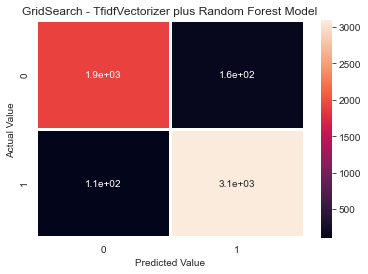

Accuracy: 0.9498106060606061


In [116]:
# get predictions
preds_gsTVRF = gs_TVRF.predict(X_test)

# save confusion matrix values
# tn, fp, fn, tp = confusion_matrix(y_test, preds_gsCVNB).ravel()

# view confusion matrix

# plot heatmap
ax = sns.heatmap(confusion_matrix(y_test, preds_gsTVRF),annot=True, linewidths=2)
ax.set(xlabel='Predicted Value', ylabel='Actual Value')
plt.title("GridSearch - TfidfVectorizer plus Random Forest Model")
plt.show()

# Accuracy of model
print(f"Accuracy: {accuracy_score(y_test, preds_gsTVRF)}")

## KNN Classifier

In [117]:
# Set a pipeline up with two stages
# 1. CountVectorizer (transformer)
# 2. KNeighborsCLassifier (estimator)

pipe_CVKNN = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('knn', KNeighborsClassifier())
])

In [118]:
%%time

# Estimate how the model will perform on unseen data
print(f"Cross Validated Score of pipline: {cross_val_score(pipe_CVKNN, X_train, y_train, cv=10).mean()}")

# fit model
pipe_CVKNN.fit(X_train, y_train)

# model score on training and testing data
print(f"Train Score: {pipe_CVKNN.score(X_train, y_train)}")
print(f"Test Score: {pipe_CVKNN.score(X_test, y_test)}")

Cross Validated Score of pipline: 0.7657467532467532
Train Score: 0.8069805194805195
Test Score: 0.7785984848484848
Wall time: 14.5 s


Score is not bad but let's expand it using a `GridSearch`.

In [119]:
# set pipeline parameters
pipe_CVKNN_params = {
    'cvec__max_features' : [2_000, 3_000, 4_000, 5_000, 6_000, 7_000, 8_000, 9_000, 10_000],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

In [120]:
# Instantiate GridSearchCV

gs_CVKNN = GridSearchCV(pipe_CVKNN,   # object being optimized
                    param_grid=pipe_CVKNN_params,  # what paramenters values are being searched
                    cv=5   # number of cross-validation
                    )

In [121]:
%%time

# fit gridsearchCV to training data
gs_CVKNN.fit(X_train, y_train)

Wall time: 2min 5s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'',
                                                                              'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                  

In [122]:
# Get Gridsearch best score
print(f"GridSearch best score: {gs_CVKNN.best_score_}")

GridSearch best score: 0.7904220779220779


In [123]:
# get the best parameters
gs_CVKNN.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=2000,
                                 stop_words=frozenset({'', 'a', 'about',
                                                       'above', 'across',
                                                       'after', 'afterwards',
                                                       'again', 'against',
                                                       'all', 'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
        

In [124]:
# gs_CVKNN model score
print(f"Train Score: {gs_CVKNN.score(X_train, y_train)}")
print(f"Test Score: {gs_CVKNN.score(X_test, y_test)}")

Train Score: 0.8331168831168831
Test Score: 0.7994318181818182


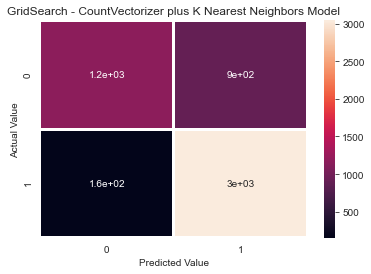

Accuracy: 0.7994318181818182


In [125]:
# get predictions
preds_gsCVKNN = gs_CVKNN.predict(X_test)

# save confusion matrix values
# tn, fp, fn, tp = confusion_matrix(y_test, preds_gsCVNB).ravel()

# view confusion matrix

# plot heatmap
ax = sns.heatmap(confusion_matrix(y_test, preds_gsCVKNN),annot=True, linewidths=2)
ax.set(xlabel='Predicted Value', ylabel='Actual Value')
plt.title("GridSearch - CountVectorizer plus K Nearest Neighbors Model")
plt.show()

# Accuracy of model
print(f"Accuracy: {accuracy_score(y_test, preds_gsCVKNN)}")

The model is not bad but let's change the transformer to `TfidfVectorizer`.

In [126]:
# Set a pipeline up with two stages
# 1. TfidfVectorizer (transformer)
# 2. KNeighborsCLassifier (estimator)

pipe_TVKNN = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop_words)),
    ('knn', KNeighborsClassifier())
])

In [127]:
# Estimate how the model will perform on unseen data
print(f"Cross Validated Score of pipline: {cross_val_score(pipe_TVKNN, X_train, y_train, cv=10).mean()}")

# fit model
pipe_TVKNN.fit(X_train, y_train)

# model score on training and testing data
print(f"Train Score: {pipe_TVKNN.score(X_train, y_train)}")
print(f"Test Score: {pipe_TVKNN.score(X_test, y_test)}")

Cross Validated Score of pipline: 0.5320616883116883
Train Score: 0.5489448051948052
Test Score: 0.5416666666666666


Score is bad but let's expand it using a `GridSearch`.

In [128]:
# set pipeline parameters
pipe_TVKNN_params = {
    'tvec__max_features' : range(2000, 10_000, 1000),
    'tvec__ngram_range' : [(1,1), (1,2)]
}

In [129]:
# Instantiate GridSearchCV

gs_TVKNN = GridSearchCV(pipe_TVKNN,   # object being optimized
                    param_grid=pipe_TVKNN_params,  # what paramenters values are being searched
                    cv=5   # number of cross-validation
                    )

In [130]:
%%time

# fit gridsearchCV to training data
gs_TVKNN.fit(X_train, y_train)

Wall time: 1min 55s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=frozenset({'',
                                                                              'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                  

In [131]:
# Get Gridsearch best score
print(f"GridSearch best score: {gs_TVKNN.best_score_}")

GridSearch best score: 0.6336038961038961


In [132]:
# get the best parameters
gs_TVKNN.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                                 stop_words=frozenset({'', 'a', 'about',
                                                       'above', 'across',
                                                       'after', 'afterwards',
                                                       'again', 'against',
                                                       'all', 'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow'

In [133]:
# gs_TVNB model score
print(f"Train Score: {gs_TVKNN.score(X_train, y_train)}")
print(f"Test Score: {gs_TVKNN.score(X_test, y_test)}")

Train Score: 0.7041396103896104
Test Score: 0.6537878787878788


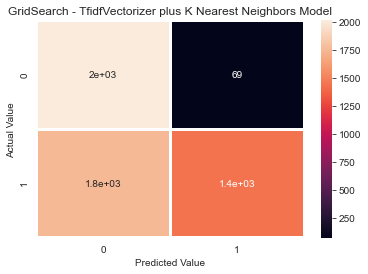

Accuracy: 0.6537878787878788


In [134]:
# get predictions
preds_gsTVKNN = gs_TVKNN.predict(X_test)

# save confusion matrix values
# tn, fp, fn, tp = confusion_matrix(y_test, preds_gsCVNB).ravel()

# view confusion matrix

# plot heatmap
ax = sns.heatmap(confusion_matrix(y_test, preds_gsTVKNN),annot=True, linewidths=2)
ax.set(xlabel='Predicted Value', ylabel='Actual Value')
plt.title("GridSearch - TfidfVectorizer plus K Nearest Neighbors Model")
plt.show()

# Accuracy of model
print(f"Accuracy: {accuracy_score(y_test, preds_gsTVKNN)}")

Let us compare the models' accuracy that has different estimator and models.

As our model's aim is to classify which subreddit a submission would likely come from, `accuracy` is a suitable metrics to access the model.

In [135]:
# (tp+tn)/(tp+fp+fn+tn)
print("Accuracy of Naive Bayes Model".center(40,"-"))
print(f"With CountVectorizer: {accuracy_score(y_test, preds_gsCVNB)}")
print(f"With TfidfVectorizer: {accuracy_score(y_test, preds_gsTVNB)}")
print()
print("Accuracy of Logistic Regression Model".center(40,"-"))
print(f"With CountVectorizer: {accuracy_score(y_test, preds_gsCVLR)}")
print(f"With TfidfVectorizer: {accuracy_score(y_test, preds_gsTVLR)}")
print()
print("Accuracy of Random Forest Model".center(40,"-"))
print(f"With CountVectorizer: {accuracy_score(y_test, preds_gsCVRF)}")
print(f"With TfidfVectorizer: {accuracy_score(y_test, preds_gsTVRF)}")
print()
print("Accuracy of K Nearest Neighbor Model".center(40,"-"))
print(f"With CountVectorizer: {accuracy_score(y_test, preds_gsCVKNN)}")
print(f"With TfidfVectorizer: {accuracy_score(y_test, preds_gsTVKNN)}")

-----Accuracy of Naive Bayes Model------
With CountVectorizer: 0.8778409090909091
With TfidfVectorizer: 0.8606060606060606

-Accuracy of Logistic Regression Model--
With CountVectorizer: 0.8875
With TfidfVectorizer: 0.9428030303030303

----Accuracy of Random Forest Model-----
With CountVectorizer: 0.9821969696969697
With TfidfVectorizer: 0.9498106060606061

--Accuracy of K Nearest Neighbor Model--
With CountVectorizer: 0.7994318181818182
With TfidfVectorizer: 0.6537878787878788


Running the above code, we see that the classifier's performance top 3 as follows:
1. Random Forest using CountVectorizer
2. Random Forest using TfidfVectorizer
3. Logistric Regression using TfidfVectorizer

Let us create the list of feature importance based on the best performing model - Random Forest using CountVectorizer.

In [136]:
# create importance, feature and std dataframe
rf_importance = pd.DataFrame({'importance': gs_CVRF.best_estimator_.named_steps['rf'].feature_importances_,
                              'feature': gs_CVRF.best_estimator_.named_steps['cvec'].get_feature_names(),
                              'std': np.std([tree.feature_importances_ for tree in gs_CVRF.best_estimator_.named_steps['rf'].estimators_], axis=0)
                             })
rf_importance.sort_values('importance', ascending=False)
# rf_importance = pd.Series(gs_CVRF.best_estimator_.named_steps['rf'].feature_importances_, index=gs_CVRF.best_estimator_.named_steps['cvec'].get_feature_names())
# rf_importance

,importance,feature,std
5981,0.129313,zoom,0.088800
5296,0.089781,team,0.110028
4462,0.069969,removed,0.027933
2993,0.014059,join,0.004058
3390,0.013697,microsoft,0.022249
...,...,...,...
5455,0.000000,tracing,0.000000
207,0.000000,3dreserved,0.000000
999,0.000000,callerservice,0.000000
1001,0.000000,calls,0.000000


In [137]:
temp = rf_importance.loc[(rf_importance['importance']>0)&(rf_importance['std']>0),:].sort_values('importance', ascending=False)
temp.head()

,importance,feature,std
5981,0.129313,zoom,0.088800
5296,0.089781,team,0.110028
4462,0.069969,removed,0.027933
2993,0.014059,join,0.004058
3390,0.013697,microsoft,0.022249


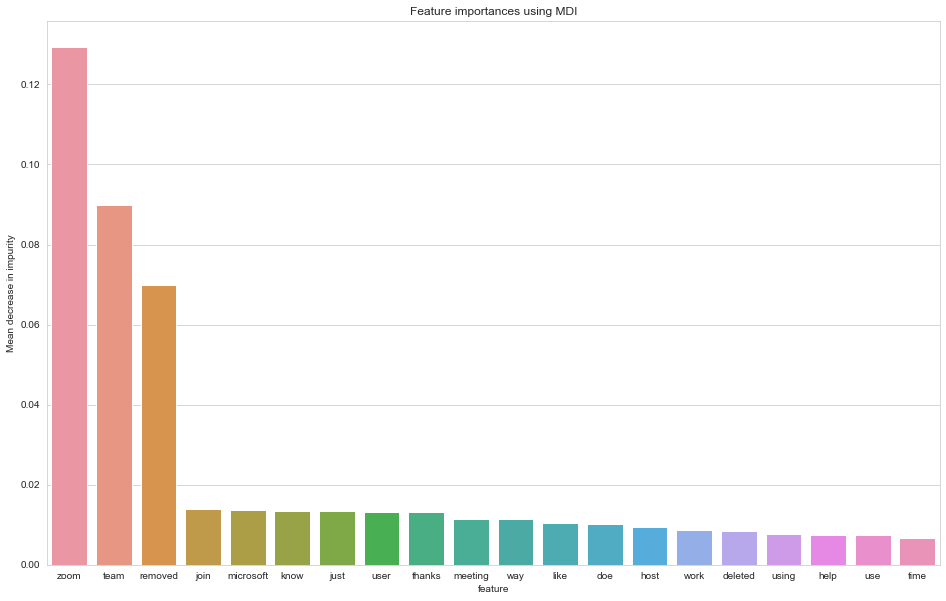

In [138]:
plt.figure(figsize=(16,10))
sns.barplot(data=temp.head(20), y='importance', x= 'feature', ci='std')
plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity");

From above graph, we see that the top 5 words affecting the model are: 
1. zoom
2. team
3. removed
4. microsoft
5. thanks

However, the intepretation of random forest is not easy to understand. Although Random Forest models have higher accuracy score, they are harder to interpret. The Logistic Regression model is more interpretable, and with a close accuracy score, it should be okay for us to draw conclusion using the Logistic Regressor instead of the random forest models.

In [139]:
# create new dataframe with 2 columns
lr_coef_df = pd.DataFrame({'feature': gs_TVLR.best_estimator_.named_steps['tvec'].get_feature_names(),
                          'coefficient': gs_TVLR.best_estimator_.named_steps['lr'].coef_[0]
                          })

# sort dataframe by size of coefficient so that we can take largest 20 and smallest 20
lr_coef_df = lr_coef_df.sort_values('coefficient', ascending=False)

# view the size and head of dataframe
print(lr_coef_df.shape)
lr_coef_df.head()

(9000, 2)


,feature,coefficient
8789,zoom,20.542743
3226,host,6.344354
6054,removed,6.307409
3617,join,3.888736
8538,webinar,3.201453


In [140]:
# view the tail of the dataframe
lr_coef_df.tail()

,feature,coefficient
7319,team meeting,-2.696917
1955,deleted deleted,-4.221214
4576,microsoft,-4.454608
6055,removed removed,-11.298782
7176,team,-16.472491


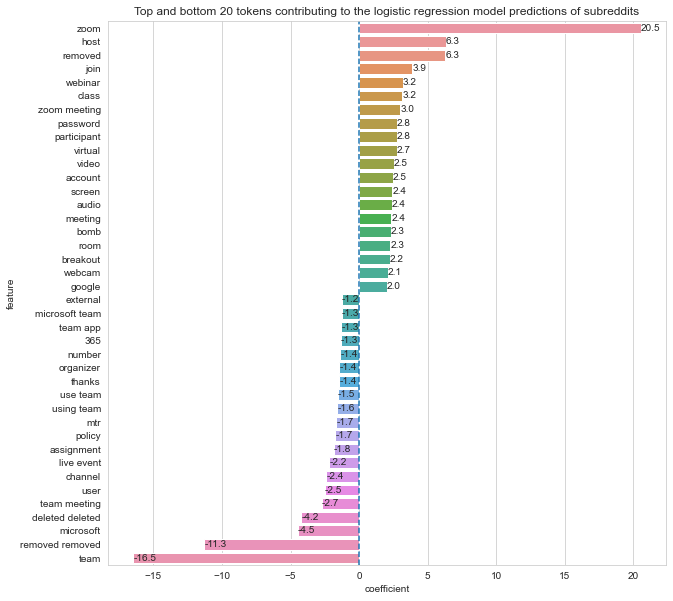

In [141]:
# set how graph size
plt.figure(figsize=(10,10))

# plot barplot of top 20 and last 20 coefficients of model
ax=sns.barplot(data=pd.concat([lr_coef_df.head(20), lr_coef_df.tail(20)]), y='feature', x='coefficient')

# set title of plot
plt.title('Top and bottom 20 tokens contributing to the logistic regression model predictions of subreddits')

# plot a dotted line at x=0, above this line (to the right), model will tend to predict class 1 (Zoom)
# below this line, model will tend to predict class 0 (MST)
plt.axvline(x=0, ls='--');

# https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
# if running matplotlib 3.4.0, else do not run the below line
# ax.bar_label(ax.containers[0])

# to comment out if running the bar_label line of code
# to set value to each bar
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 0,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.1f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

The coefficients of Logistic Regression measures the degree which the target variable (in this case `Zoom`/`1` or `Microsoft Teams`/`0`) is sensitive to the feature. A larger absolute value of the coefficients implies that the target is more sensitive towards that feature. 

For feature with coefficient $x$, we can interpret that for every increase of 1 in the feature, it will lead to an increase of $exp(x)$-1 probability of getting target variable of `1`. 

We can see that these identified variables have a large impact as the values are more than 1.  

From the above graph, we see that the words "zoom" has the largest positive coefficient and "team" has the largest negative coefficient. This comes as no surprise seeing that the words are (part of) the name of the video conferencing tool. 

---

## Conclusion and Recommendation

### EDA

During EDA, we looked at the wordclouds, top 20 words for `Zoom` and `Microsoft Teams`, Sentiment Analysis and Time Period of the submissions. 

We made the following conclusion for Sentiment Analysis on the submissions:

__Compound score:__

| subreddit | count | mean | std | min | 25% | 50% | 75% | max |
|-|-|-|-|-|-|-|-|-|
| MicrosoftTeams | 12946.0 | 0.258201 | 0.600570 | -0.9988 | 0.0 | 0.0000 | 0.8796 | 0.9998 |
| Zoom | 15018.0 | 0.188739 | 0.465608 | -0.9977 | 0.0 | 0.0772 | 0.5719 | 0.9992 |

We can see that although the score for `Microsoft Teams` is higher than `Zoom`, more users seems to be feeling positive about `Zoom` as compared to `Microsoft Teams` as there is more than 50% of the data having positive compound score. 

### Conclusion of model

Estimator used:
1. CountVectorizer
2. TfidfVectorizer

Classifier Models created:
1. Logistic regression
2. Naive Bayes
3. Random Forest
4. K Nearest Neighbors

Using Pipeline and GridSearchCV, we ran the models and the top 3 results are as follows:

| Transformer | Estimator | Accuracy |
|-|-|-|
| CountVectorizer | Random Forest | 0.9816287878787879 |
| TfidfVectorizer | Random Forest | 0.94375 |
| TfidfVectorizer | Logistric Regression | 0.9428030303030303 |

However, the intepretation of random forest is not easy to understand. Although Random Forest models have higher accuracy score, they are harder to interpret. The Logistic Regression model is more interpretable, and with a close accuracy score, we drew conclusion using the logistic regression model. 

### Recommendations

Looking back to our problem statement, we can make the following recommendations:
1. Software Development Team:

Running the below code, we can see some of the common issues that is causing people to be unhappy with `Zoom`. 

Issues faced for Zoom: 
- Interface on Linux
- Zoom for class / Webinar
- Internet Connection issue
- Microphone and Video Options to default as off
- Audio quality

In [142]:
# look at top 20 posts with negative compound sentiment analysis score
combined_df.sort_values('com_sen_analysis').loc[combined_df['subreddit']=='Zoom',['post', 'com_sen_analysis']].head(20)

,post,com_sen_analysis
2373,roses are red violets are blue I HATE FURRIES I hate furries I hate furries I hate furries I hate furriesI hate furriesI hate furriesI hate furriesI hate furriesI hate furriesI hate furriesI hate furriesI hate furriesI hate furriesI hate furriesI hate furriesI hate furriesI hate furriesI hate furriesI hate furriesI hate furries,-0.9977
2569,"£112 bill from zoom Just had an actual panic attack when I opened my phone bill- normally £19/month, but this time I was faced with a cracking £131.\n\nThought it must have been a mistake, but no, I'm an actual moron. At the start of the lockdown I joined a zoom work meeting for 43 mins, but made the fatal mistake of dialling in on my phone. I am \*certain\* at no point charges were mentioned,...",-0.9865
7502,Requiring Participation My teacher is going to do this thing where she will give extra credit to students who keep their cameras on. I really don't like the way I look. I couldn't look in the mirror for a while and I'm still having a hard time doing that. She also doesn't call on students with their cameras off so my participation grade isn't great. I can talk and respond but she never asks me...,-0.9841
10716,"Zoom has horrible support on linux. Seriously zoom just focuses on Apple and Windows ONLY! The linus support is horrendous. It doesn't even have the newest features. There is no raise hand button. and there are no emotes. There are bugs everywhere. there is a 50/50 chance on getting stuck on the meeting connect screen. and sometimes the built in audio setting is just silent. switching to ""same...",-0.9827
10068,"Why Does My Teacher Screensharing IMMEDIATELY Pull Me Back Into Zoom? A lot of my teachers don't screenshare for everyone, but do it incase there is info some people may have missed and such. But when I'm trying to work during class, this is EXTREMELY annoying, as the sentence I'm writing will be cut off three times in a row while my teacher accidentally shares the wrong thing and etc. I use t...",-0.9808
12372,"Error 1132 - Won't Sign In or Let Me Join a Meeting I use Zoom for online classes, and it was working like a charm on my personal computer. But, a few days ago, I had to use a different PC due to personal reasons. It didn't have Zoom, so I installed the latest version from the website and proceeded to sign into my existing account, and that is when it showed me the ""Failed To Sign In. Error 11...",-0.9800
2960,"Bad Zoom Experience: Will it Recur? How to Avoid? Hi,\n\nRecently we had a Zoom meeting with 9 people where everything went bad. From the start almost all participants were displayed in smaller boxes with notes that their connection speed was slow. Sometimes an image would freeze, disappear, or update irregularly. The sound was terrible: sometimes no sound for several seconds, sometimes noi...",-0.9777
5107,"Error Code 1132: Failed to login I am unable to login on my personal computer to the Zoom app. I get an error code 1132. I deleted my account and made a new account and I still get the same error when trying to login on my computer using the Zoom app. I can still login to my Zoom account through the Internet browser, but I cannot create or join meetings. I eventually made a new account and...",-0.9775
3262,"HELP!!! Can the teacher/host track me from Zoom? Hello, Yesterday I had an online class through zoom with a really cruel and mean teacher. I used my regular name as my username, but then I had a stupid idea after she told us that even though we dont have any books to study she doesn't care and the exams will be the same as previous years, and that we should be thankful that she bothers to teac...",-0.9743
593,"[HELP] Zoom meeting password entered correctly but still says incorrect. I'm using the latest version (as of 6th April 2020).\n\nI've been having problems with the meeting password thingy, the password is simple as hell (12345) yet It still says I entered it incorrectly. I'm pretty sure I've entered it correctly

2. Marketing: 

Running the below codes, we can see some of the common issues faced by the `Microsoft Teams` users and the top 10 words associated towards `Microsoft Teams`. 

Issues faced for Microsoft Teams:
- Interface on Linux
- Sign-in issues
- Audio issues
- Chat features (not applicable in `Zoom`)

It seems like the issues faced by the `Zoom` and `Microsoft Teams` are similar, so if the software development team is able to resolve the issues first, then we can use that as selling points of `Zoom` as the preferred video conferencing tool. 

Top 10 Words that tends to be associated towards `Microsoft Teams`:
- team
- removed
- microsoft
- team meeting
- user
- channel
- live event
- assignment
- policy
- 365

We can consider adding these words for our Search Engine Marketing and Search Engine Optimisation campaigns and to utilise these words as paid keywords such as Google AdWords or organic keywords in our sites.

In [143]:
# look at top 20 posts with negative compound sentiment analysis score
combined_df.sort_values('com_sen_analysis').loc[combined_df['subreddit']=='MicrosoftTeams',['post', 'com_sen_analysis']].head(20)

,post,com_sen_analysis
20121,"Hi.\n\nMy name is Andrew Mason. I'm a 10th grade student who knows a bit about computers, and I feel reasonably qualified to make some of the controversial, even downright hostile claims about Teams that I'm going to make.\n\nThat said, there may be some instances where my complaints can be easily linked to ""operator error."" If you all have any fixes to these problems, please let me know in t...",-0.9988
17548,"Using 1.3.00.5153 on linux. \n\nLogging in works, but then the client informs me ""There was a glitch and we're recovering"" and restarts a couple of times before it asks me to log in again. Can briefly see my chats and teams before the client restarts.\n\nThis client version has worked fine since I installed it April 24. Not sure when it started to act up, but it is a static binary. It should n...",-0.9985
21956,"My company has been using MS Teams for 2 years now, and I am the system admin. I decided to compile here a list of all my frustrations with MS Teams. It is a great tool, but several unfixed bugs and annoyances really piss me off.\n\n1. No Reply (quote) on desktop apps. - Seriously? It has been over 2 years and they STILL can't implement this on the desktop apps? It just makes the mobile-deskto...",-0.9985
20868,"Hello everyone,\n\n&amp;#x200B;\n\nWe have a problem with some customers that used Polycom VVX.\n\nwhen we tried to connect to Teams (Teams only) by **web sign in**.\n\n**we get this Error - Skype for business authentication failed. sign in again.**\n\n\*the user without MFA.\n\nit seems like something changed on the gateway of Microsoft.\n\n \n\nAny suggestions?\n\n&amp;#x200B;\n\nhttps://pre...",-0.9981
22799,"Hello, I am having trouble enabling the NDI of teams.\n\nI've set NDI to on in our global permissions so everybody in my org has access to use it. When I want to enable it in the permission i get the following message:\n\n**There was a problem downloading the file**\n\nTry turning NDI on again.\n\nNo matter what I do I can't fix it. I tried to activate it on 5 different PCs and 2 macs. Only on...",-0.9975
18055,"I am having issues with a Windows 7 Professional system with Teams only working once after install. If you remove and reinstall it again, it works for 1 more session. When trying to login, it has the users full email, click sign in and get error code 6. Anyone come across this?\n\n&amp;#x200B;\n\n`Thu Jul 23 2020 12:39:28 GMT-0400 (Eastern Daylight Time) &lt;10664&gt; -- warning -- No saved co...",-0.9967
15238,"Part of a pretty big group, in which I've been really pushing TEAMS. Our company has us on Teams for conference calls (video, etc). Embarassed to say we've been using GroupMe for some time prior to TEAMS. But when we stopped using WebEx for our calls we went to TEAMS and I proposed we go ""full-in"" with TEAMS - eliminating GroupMe altogether.\n\nFail. We've tried for 5 months now (chat) and non...",-0.9951
25719,"So I wanted to change my pfp and ended up choosing the wrong pic and it's a slightly embarrassing one but I didn't really care and told myself to fix tomorrow,\nThe problem is that I can't change it now because an admin stopped that property or something, and I'm too embarrassed to contact them, not to mention that I don't know how to do so anyways\n\nWhat on earth can I do to fix this disaste...",-0.9945
16757,"Hi!\n\nSince a couple of days I get the error ""We weren't able to connect. Sign in and we'll try again. Sign in"" in MS Teams. It is an Citrix environment on Server 2016 and on-prem ADFS. Teams is installed with the MSI and ALLUSER ALLUSERS parameters (machine wide install).\n\nI found a post that states that I should enable the WS-Trust 1.3 windowstransport but that is allready enabled. Also,...",-0.9943
18215,"Dear Microsoft.\nThis is the second time I have written you off as a shambling entity disinterested in pursuing client relations. You probably have just written me off already but let's face it. This message was always g

In [144]:
# words frequently associated with micrsoft teams
lr_coef_df.tail(20)

,feature,coefficient
2520,external,-1.234326
4594,microsoft team,-1.268879
7190,team app,-1.298428
149,365,-1.349562
4937,number,-1.370433
5119,organizer,-1.427365
7530,thanks,-1.437322
8049,use team,-1.530442
8244,using team,-1.574015
4714,mtr,-1.665662


### Ways to improve

- Add more words to stop words such as 'thanks', 'removed' as model stop words as this affects sentiment analysis but not for model prediction. 
- To include other subreddit of other video conferencing tools like Webex ([link](https://www.reddit.com/r/webex/)).
- Filter out posts that are of 'spamming' nature. E.g. Row 2373 post has no relation to `Zoom` or `Microsoft Teams`.